# Introduction to Reinforcement Learning Assignment
## University of Zürich Spring 2022
## Barış Özakar
## March 2022

In [1]:
# Import 
import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
import Chess_env as Chess_envb
import Chess_env_with_draw_punishment as Chess_env_with_draw_punishment
from tqdm import tqdm
import pandas as pd
import collections

size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game: The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S: $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X: $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a: $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep: The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features: Given the chessboard position, the method computes the features.

### Random agent with draw reward R=0

In [2]:
# PERFORM N_episodes=10000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 
np.random.seed(2022)
env=Chess_env.Chess_Env(size_board)
S,X,allowed_a=env.Initialise_game()
N_episodes=10000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])
Draw_save_random = np.zeros([N_episodes, 1])
Checkmate_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            if R==1:
                Checkmate_save_random[n] = np.copy(1)
                Draw_save_random[n] = np.copy(0)
            else:
                Checkmate_save_random[n] = np.copy(0)
                Draw_save_random[n] = np.copy(1)
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER

# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT IS NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

In [3]:
print('Random_Agent with 0 draw reward','\nAverage reward:', np.mean(R_save_random),'\nAve # of steps: ', np.mean(N_moves_save_random), '\nDraw %:', np.sum(Draw_save_random)/N_episodes, '\nCheckmate %:', np.sum(Checkmate_save_random)/N_episodes)

Random_Agent with 0 draw reward 
Average reward: 0.199 
Ave # of steps:  6.9736 
Draw %: 0.801 
Checkmate %: 0.199


### Here we see that with a draw reward of 0, on average, a random agent gets an "expected reward" of 0.2, with 80% of games ending in draw. Hence, if we were to introduce a draw reward of -1, the "expected reward" of a random agent would be -0.6=-1x80%+1x20%

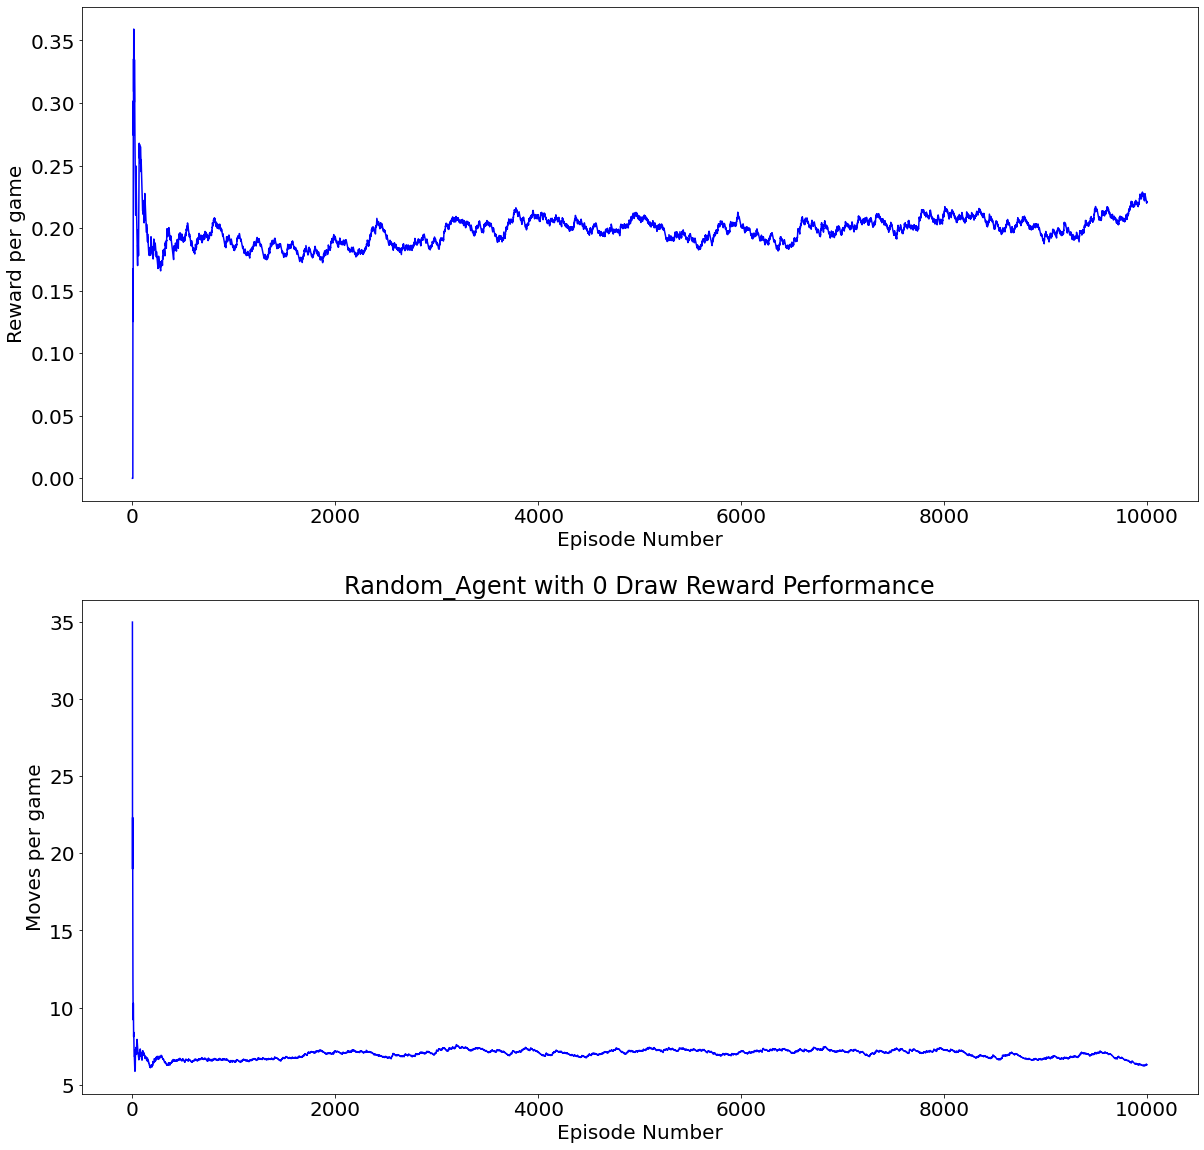

In [4]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 20})

## PLOT THE REWARD PER EPISODE AS TRAINING PROGRESSES
R_ema_random = pd.DataFrame(R_save_random).ewm(span=N_episodes/10).mean()
fig, (ax1, ax2)=plt.subplots(2,1)
ax1.plot(R_ema_random, 'b')
ax1.set(xlabel='Episode Number', ylabel='Reward per game')

## PLOT THE NUMBER OF MOVES PER EPISODE AS TRAINING PROGRESSES
Moves_ema_random = pd.DataFrame(N_moves_save_random).ewm(span=N_episodes/10).mean()
ax2.plot(Moves_ema_random, 'b')
ax2.set(xlabel='Episode Number', ylabel='Moves per game')
plt.title('Random_Agent with 0 Draw Reward Performance')
plt.show()

# SARSA

<img src="SARSA_valueFunctionApprox_scheme.png" width="1000" height="700">

### First I will use the Sigmoid activation function and hence the backpropagation scheme will look like:
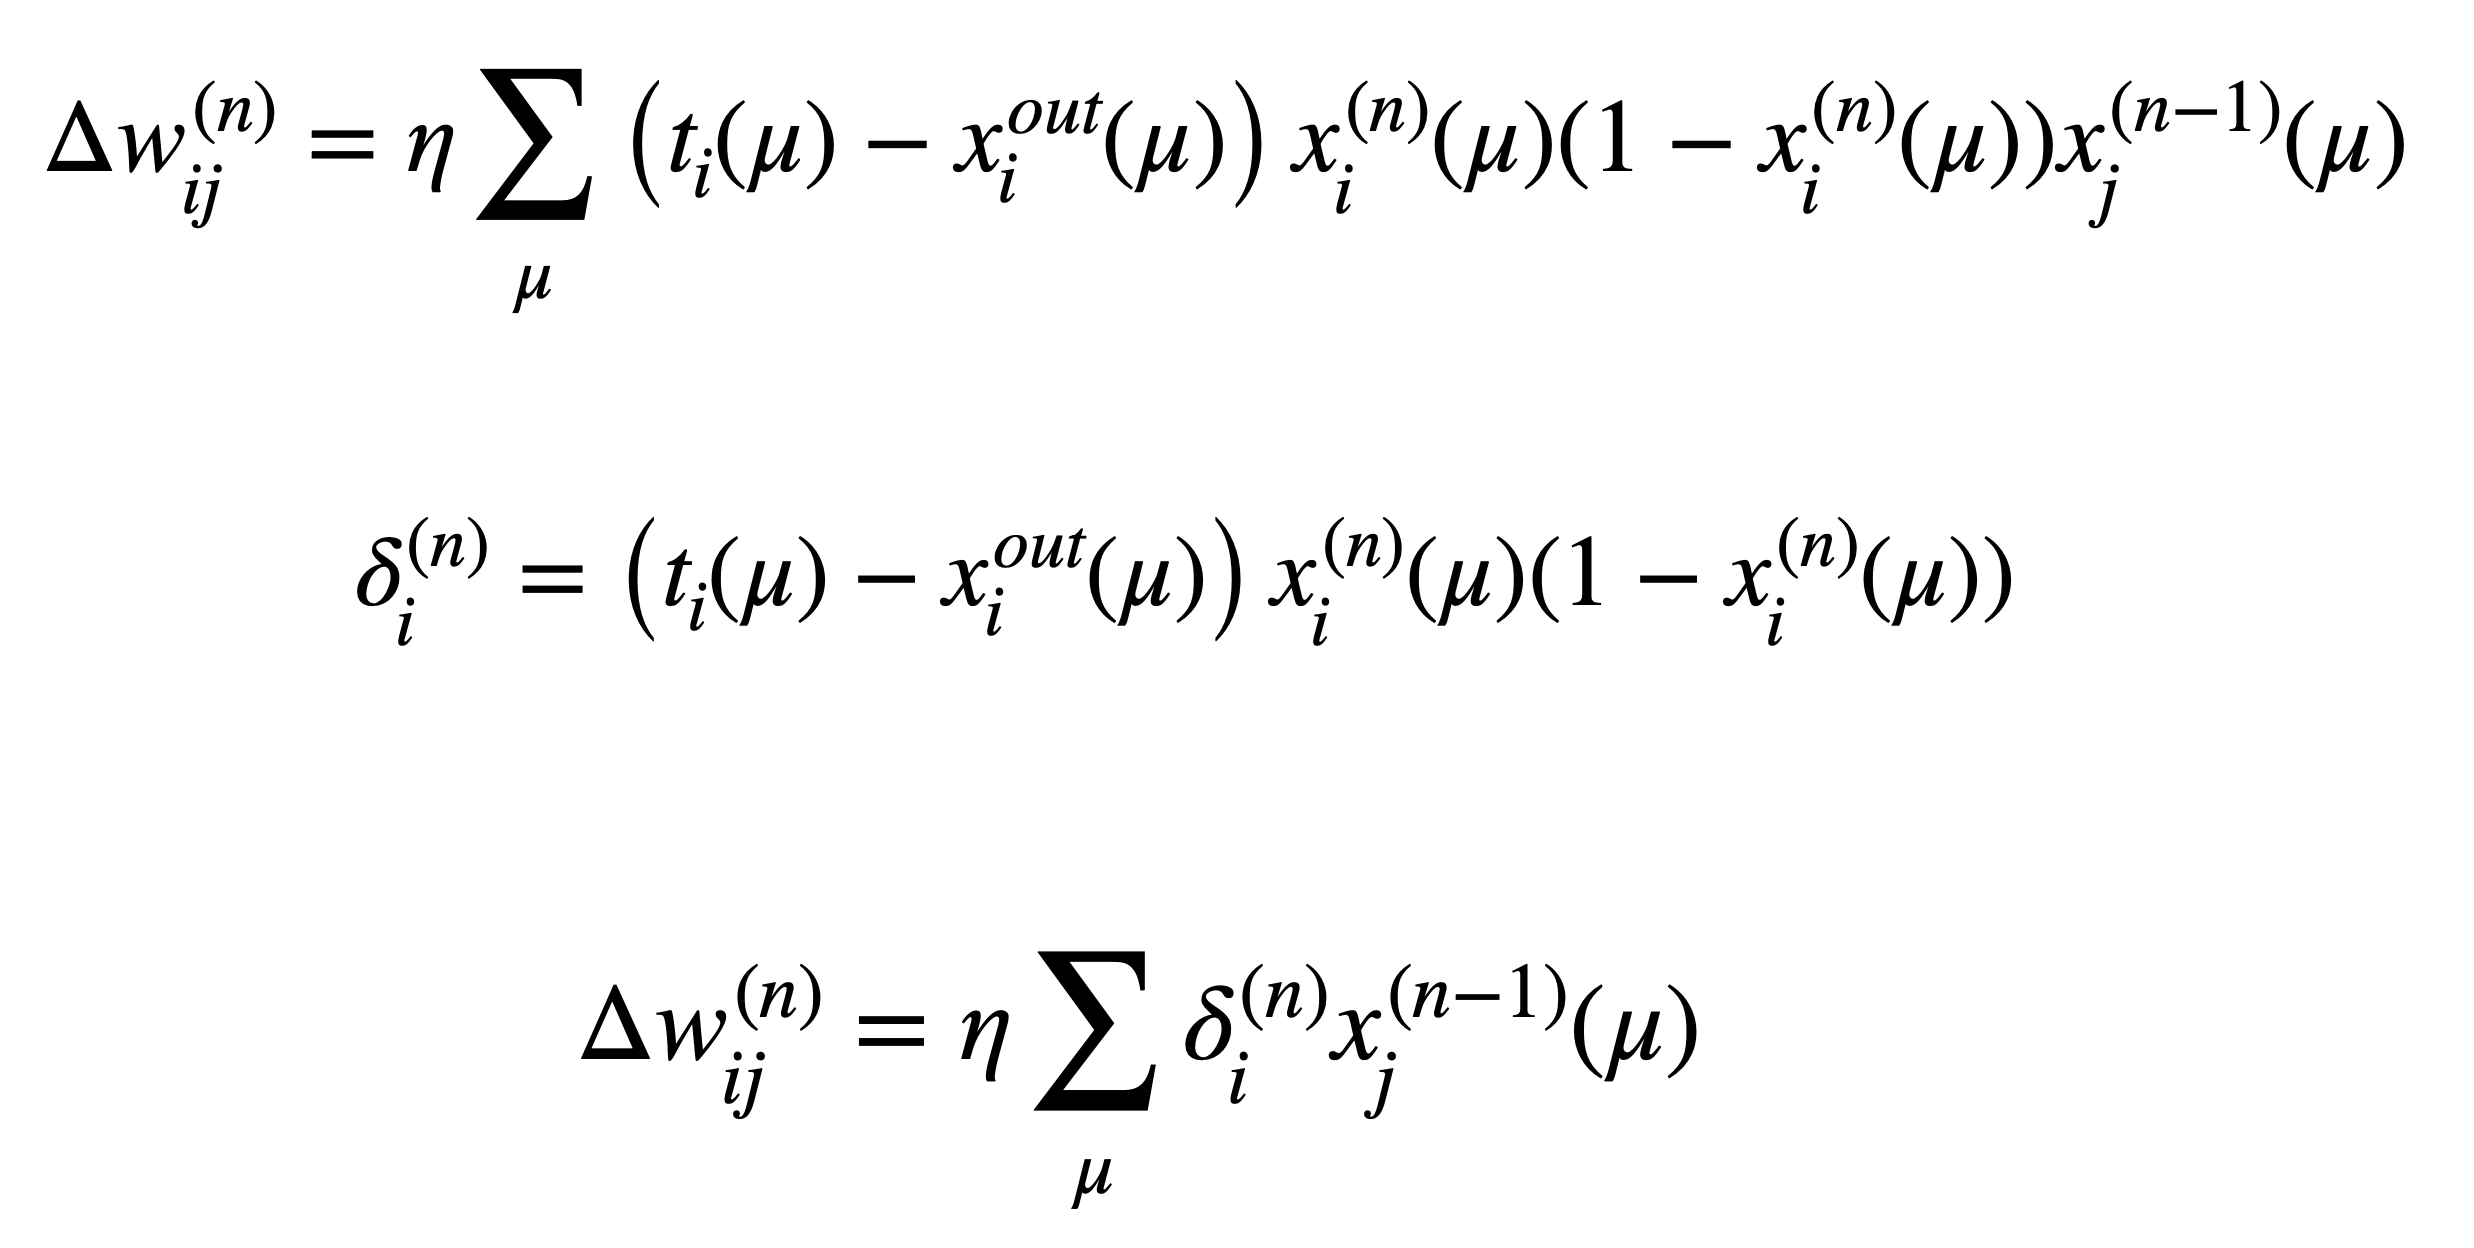
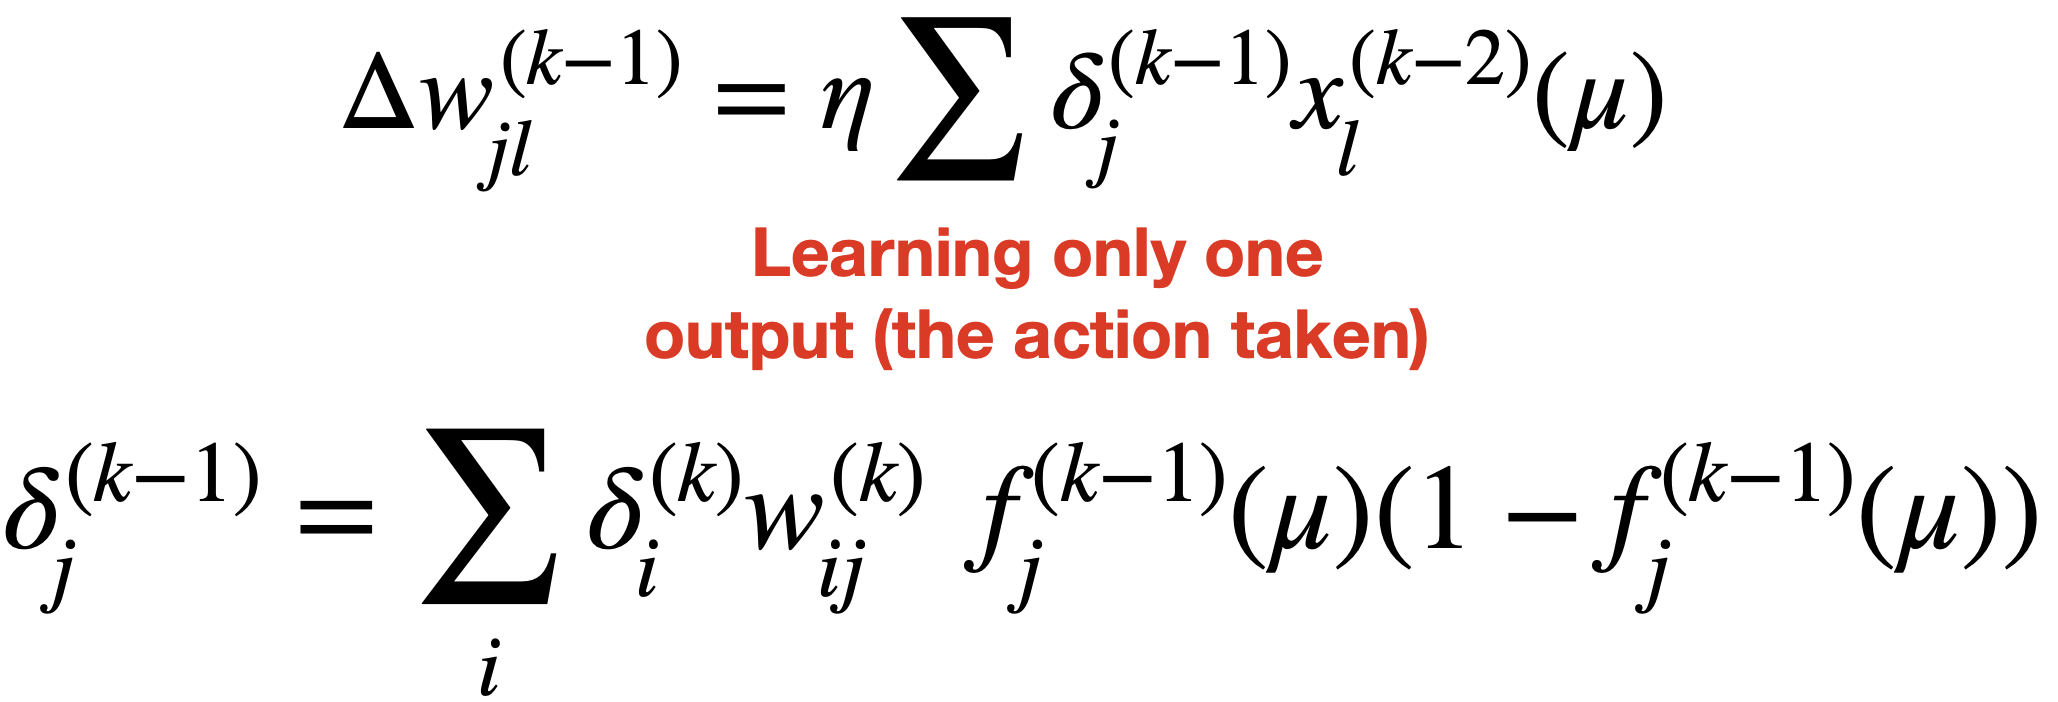
### Realize: We update only the parameters corresponding to the actions taken

In [5]:
## DEFINE THE EPSILON-GREEDY POLICY

def EpsilonGreedy_Policy(Qvalues, allowed_a, epsilon):
    
    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon

    if rand_a==True:
        allowed_actions_args=[i for i,v in enumerate(Qvalues*allowed_a.reshape(-1)) if v>0]
        a=np.random.permutation(allowed_actions_args)[0]

    else:
        a=np.argmax(Qvalues*allowed_a)
            
    return a

## Vanilla SGD SARSA with Draw reward R=0

In [6]:
#Set random seed to 2022 for reproducibility
np.random.seed(2022)
#initialize the environment (this uses draw reward=0)
env=Chess_env.Chess_Env(size_board)
S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

## INITALISE THE NEURAL NETWORK...

#Normalized Xavier Init: (sqrt(6.0) / sqrt(n_rows + n_cols))
W1 = np.random.normal(0, scale=np.sqrt(6/(N_h + N_in)), size=(N_h, N_in))
W2 = np.random.normal(0, scale=np.sqrt(6/(N_a + N_h)), size=(N_a, N_h))

# Initialize the biases
bias_W1 = np.zeros((N_h,))
bias_W2 = np.zeros((N_a,))

# SAVING VARIABLES
R_save_SARSA_0 = np.zeros([N_episodes, 1])
N_moves_save_SARSA_0 = np.zeros([N_episodes, 1])
Draw_save_SARSA_0 = np.zeros([N_episodes, 1])
Checkmate_save_SARSA_0 = np.zeros([N_episodes, 1])

In [7]:
for n in tqdm(range(N_episodes)):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME
   # print("episode",n)                          ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING
    
    while Done==0:                           ## START THE EPISODE
        
        # Find the Qvalues corresponding to that state
        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1

        # Apply the sigmoid function
        x1 = 1/(1+np.exp(-h1))

        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2

        # Apply the sigmoid function
        Qvalues = 1/(1+np.exp(-h2))

        # Make an action
        action = EpsilonGreedy_Policy(Qvalues, allowed_a.reshape(-1), epsilon_f)

        S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)
        

        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            if R==1:
                Checkmate_save_SARSA_0[n] = np.copy(1)
                Draw_save_SARSA_0[n] = np.copy(0)
            else:
                Checkmate_save_SARSA_0[n] = np.copy(0)
                Draw_save_SARSA_0[n] = np.copy(1)

            R_save_SARSA_0[n] = np.copy(R)
            N_moves_save_SARSA_0[n] = np.copy(i)
            
            # Compute the error signal
            e_n = R - Qvalues[action]

            # Backpropagation: output layer -> hidden layer
            delta2 = Qvalues*(1-Qvalues) * e_n
            dW2 = np.outer(delta2, x1)
            
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1, X)
            
            dbias_W1 = delta1
            
            #Update W1 and W2 only for the action taken
            W2[action, :] += eta*dW2[action, :]
            W1[action, :] += eta*dW1[action, :]
            bias_W2[action] += eta*dbias_W2[action]
            bias_W1[action] += eta*dbias_W1[action]

            break;
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            # Neural activation: input layer -> hidden layer
            h1 = np.matmul(W1, X_next)+bias_W1
            
            # Apply the sigmoid function
            x1 = 1/(1+np.exp(-h1))
            
            # Neural activation: hidden layer -> output layer
            h2 = np.dot(W2,x1)+bias_W2
           
            # Apply the sigmoid function
            next_Qvalues = 1/(1+np.exp(-h2))
            
            next_action = EpsilonGreedy_Policy(next_Qvalues, allowed_a_next.reshape(-1), epsilon_f)

            # Compute the error signal
            e_n = (R + gamma * next_Qvalues[next_action] - Qvalues[action])

            # Backpropagation: output layer -> hidden layer
            delta2 = Qvalues*(1-Qvalues) * e_n
            dW2 = np.outer(delta2, x1)
            
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1, X)
            
            dbias_W1 = delta1
            
            #Update W1 and W2; b1 and b2 only for the action taken
            W2[action, :] += eta*dW2[action, :]
            W1[action, :] += eta*dW1[action, :]
            bias_W2[action] += eta*dbias_W2[action]
            bias_W1[action] += eta*dbias_W1 [action]
            
            
            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
        
        

        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

100%|██████████| 100000/100000 [13:21<00:00, 124.82it/s]


In [8]:
print('Vanilla SARSA Agent with 0 draw reward','\nAverage reward:', np.mean(R_save_SARSA_0),'\nAve # of steps: ', np.mean(N_moves_save_SARSA_0), '\nDraw %:', np.sum(Draw_save_SARSA_0)/N_episodes, '\nCheckmate %:', np.sum(Checkmate_save_SARSA_0)/N_episodes)

Vanilla SARSA Agent with 0 draw reward 
Average reward: 0.51348 
Ave # of steps:  10.88195 
Draw %: 0.48652 
Checkmate %: 0.51348


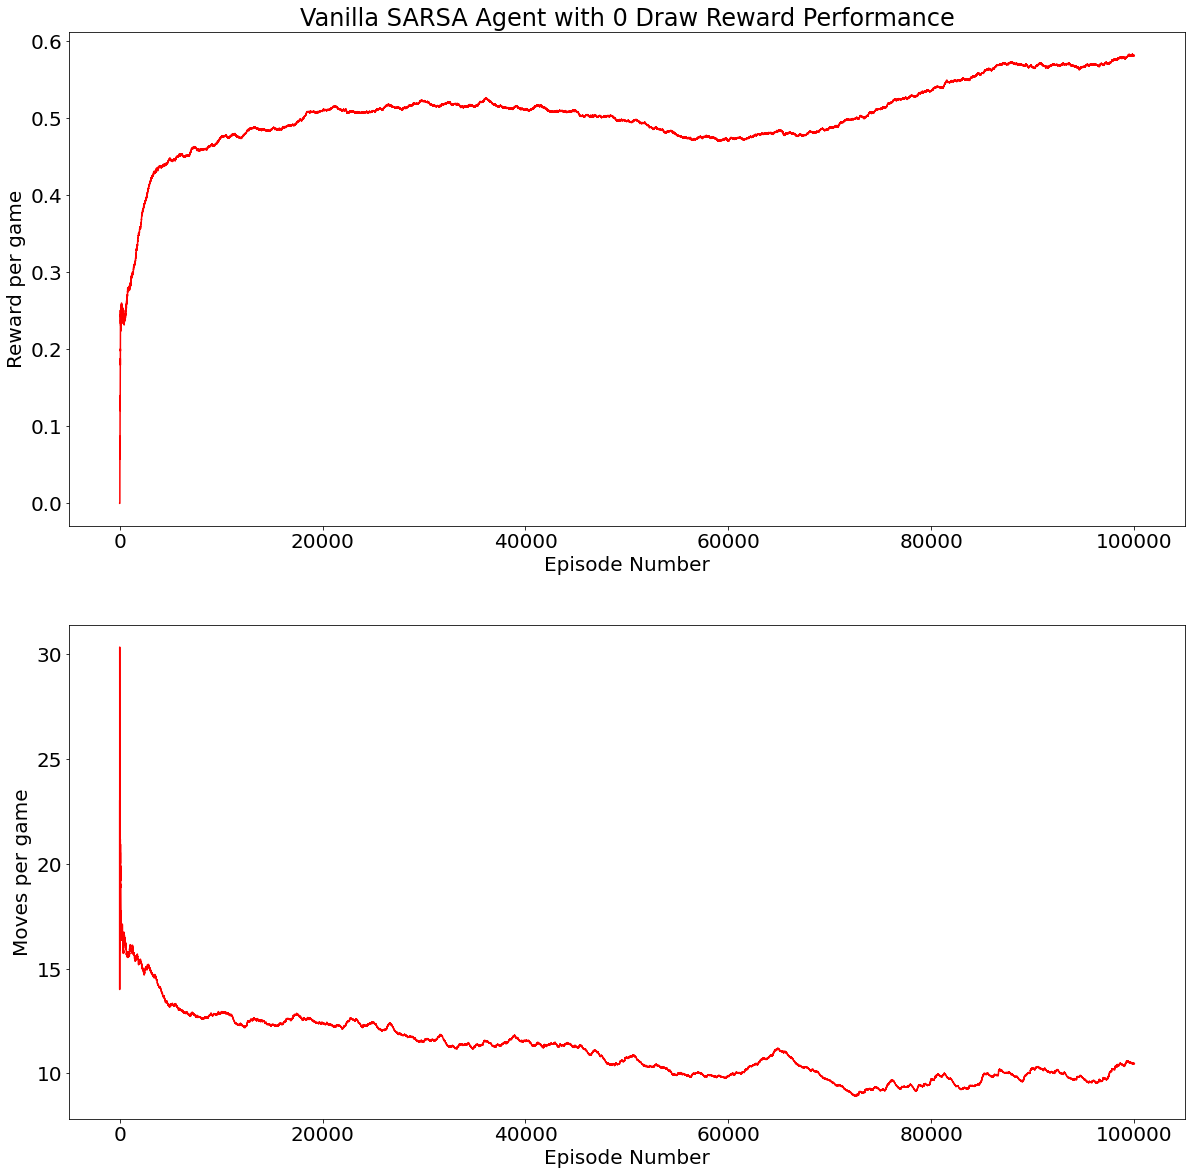

In [9]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 20})

## PLOT THE REWARD PER EPISODE AS TRAINING PROGRESSES
R_ema_SARSA_0 = pd.DataFrame(R_save_SARSA_0).ewm(span=N_episodes/10).mean()
fig, (ax1, ax2)=plt.subplots(2,1)
ax1.title.set_text('Vanilla SARSA Agent with 0 Draw Reward Performance')
ax1.plot(R_ema_SARSA_0, 'r')
ax1.set(xlabel='Episode Number', ylabel='Reward per game')

## PLOT THE NUMBER OF MOVES PER EPISODE AS TRAINING PROGRESSES
Moves_ema_SARSA_0 = pd.DataFrame(N_moves_save_SARSA_0).ewm(span=N_episodes/10).mean()
ax2.plot(Moves_ema_SARSA_0, 'r')
ax2.set(xlabel='Episode Number', ylabel='Moves per game')
plt.show()

### Vanilla SGD SARSA with Draw reward R=-1
In this part I experimented with changing the reward for draws from 0 to -1, in order to push the agent to more strongly prefer checkmates over draws

In [10]:
#INITIALIZE THE ENVIRONMENT (THIS USES DRAW REWARD -1)
env=Chess_env_with_draw_punishment.Chess_Env(size_board)

In [11]:
#Set random seed to 2022 for reproducibility
np.random.seed(2022)

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# INITALISE THE NEURAL NETWORK...

#Normalized Xavier Init: (sqrt(6.0) / sqrt(n_rows + n_cols))
W1 = np.random.normal(0, scale=np.sqrt(6/(N_h + N_in)), size=(N_h, N_in))
W2 = np.random.normal(0, scale=np.sqrt(6/(N_a + N_h)), size=(N_a, N_h))

# Initialize the biases
bias_W1 = np.zeros((N_h,))
bias_W2 = np.zeros((N_a,))


# SAVING VARIABLES
R_save_SARSA = np.zeros([N_episodes, 1])
N_moves_save_SARSA = np.zeros([N_episodes, 1])
Draw_save_SARSA = np.zeros([N_episodes, 1])
Checkmate_save_SARSA = np.zeros([N_episodes, 1])

In [12]:
for n in tqdm(range(N_episodes)):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME
   
    while Done==0:                           ## START THE EPISODE
        
        # Find the Qvalues corresponding to that state
        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1

        # Apply the sigmoid function
        x1 = 1/(1+np.exp(-h1))

        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2

        # Apply the sigmoid function
        Qvalues = 1/(1+np.exp(-h2))

        # Make an action
        action = EpsilonGreedy_Policy(Qvalues, allowed_a.reshape(-1), epsilon_f)

        S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)
        

        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            if R==1:
                Checkmate_save_SARSA[n] = np.copy(1)
                Draw_save_SARSA[n] = np.copy(0)
            else:
                Checkmate_save_SARSA[n] = np.copy(0)
                Draw_save_SARSA[n] = np.copy(1)
            
            R_save_SARSA[n] = np.copy(R)
            N_moves_save_SARSA[n] = np.copy(i)
            
            # Compute the error signal
            e_n = R - Qvalues[action]

            # Backpropagation: output layer -> hidden layer
            delta2 = Qvalues*(1-Qvalues) * e_n
            dW2 = np.outer(delta2, x1)
            
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1, X)
            
            dbias_W1 = delta1
            
            #Update W1 and W2 only for the action taken
            W2[action, :] += eta*dW2[action, :]
            W1[action, :] += eta*dW1[action, :]
            bias_W2[action] += eta*dbias_W2[action]
            bias_W1[action] += eta*dbias_W1[action]

            break;
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            # Neural activation: input layer -> hidden layer
            h1 = np.matmul(W1, X_next)+bias_W1
            
            # Apply the sigmoid function
            x1 = 1/(1+np.exp(-h1))
            
            # Neural activation: hidden layer -> output layer
            h2 = np.dot(W2,x1)+bias_W2
           
            # Apply the sigmoid function
            next_Qvalues = 1/(1+np.exp(-h2))
            
            next_action = EpsilonGreedy_Policy(next_Qvalues, allowed_a_next.reshape(-1), epsilon_f)

            # Compute the error signal
            e_n = (R + gamma * next_Qvalues[next_action] - Qvalues[action])

            # Backpropagation: output layer -> hidden layer
            delta2 = Qvalues*(1-Qvalues) * e_n
            dW2 = np.outer(delta2, x1)
            
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1, X)
            
            dbias_W1 = delta1
            
            #Update W1 and W2; b1 and b2 only for the action taken
            W2[action, :] += eta*dW2[action, :]
            W1[action, :] += eta*dW1[action, :]
            bias_W2[action] += eta*dbias_W2[action]
            bias_W1[action] += eta*dbias_W1 [action]
            
            
            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
        

        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

100%|██████████| 100000/100000 [36:45<00:00, 45.33it/s]


In [13]:
print('Vanilla SARSA_Agent with -1 draw reward','\nAverage reward:', np.mean(R_save_SARSA),'\nAve # of steps: ', np.mean(N_moves_save_SARSA), '\nDraw %:', 100*np.sum(Draw_save_SARSA)/N_episodes, '\nCheckmate %:', 100*np.sum(Checkmate_save_SARSA)/N_episodes)

Vanilla SARSA_Agent with -1 draw reward 
Average reward: 0.50888 
Ave # of steps:  31.14282 
Draw %: 24.556 
Checkmate %: 75.444


### Realize: Although the average reward is slightly lower than the previous agent that was trained with 0 draw reward (this is expected since we introduce a negative reward that brings down the "expected reward" of a random agent from 0.2 to -0.6), the percentage of games that ended with a checkmate is significantly higher (from 51% to 75%). Therefore, we can safely conclude that we achieve a better performance chess agent by training with a negative draw reward. Therefore, all of the remaining agents will be trained in the negative draw reward environment.

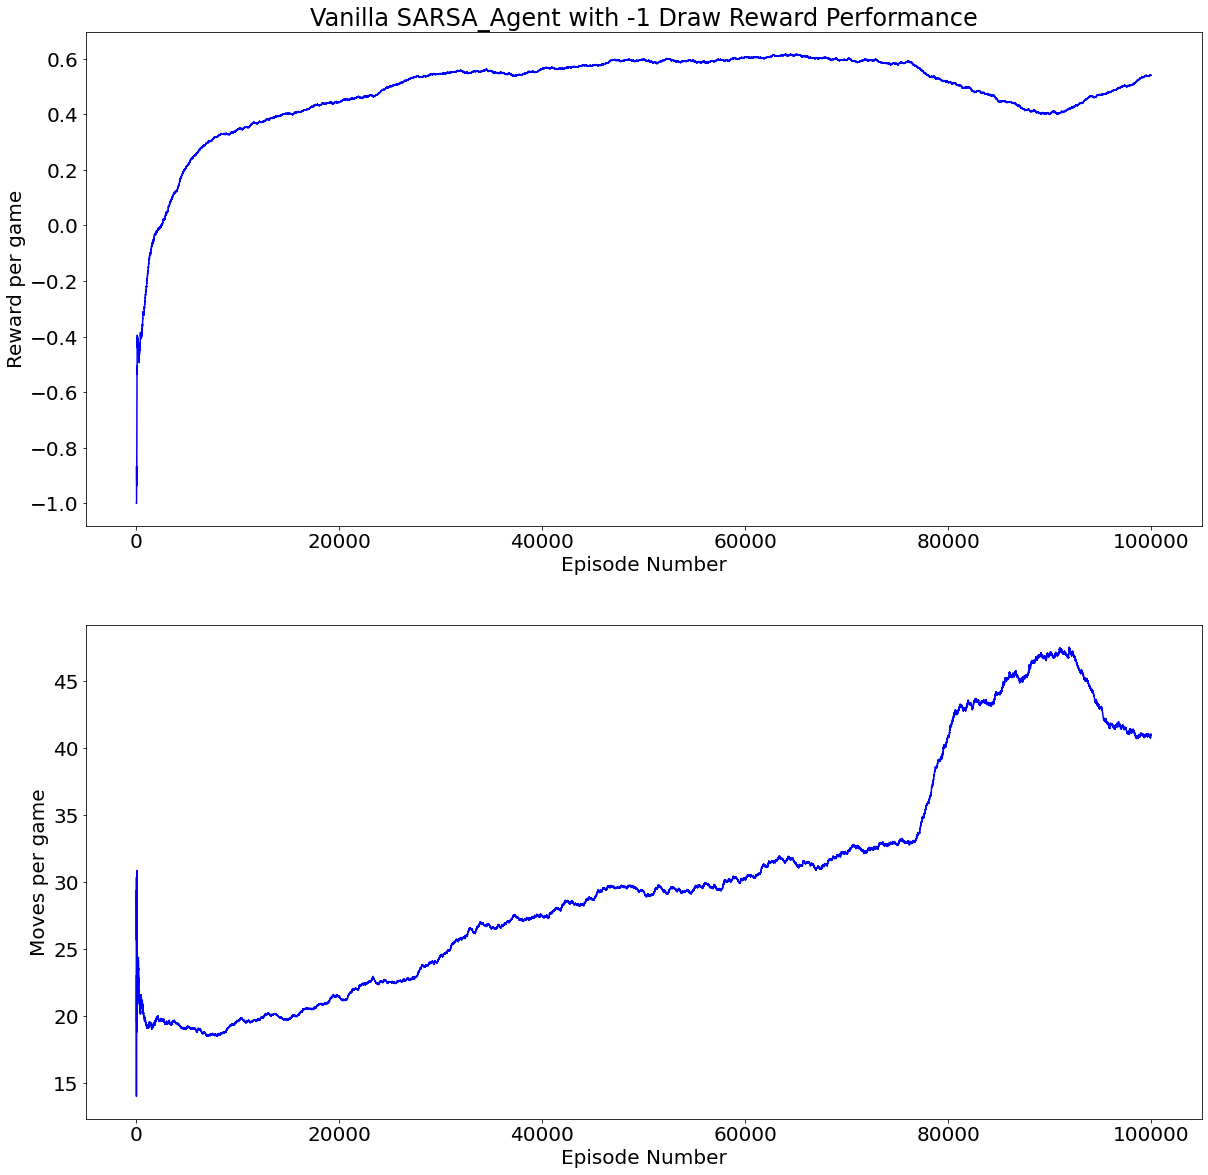

In [37]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 20})

## PLOT THE REWARD PER EPISODE AS TRAINING PROGRESSES
R_ema_SARSA = pd.DataFrame(R_save_SARSA).ewm(span=N_episodes/10).mean()
fig, (ax1, ax2)=plt.subplots(2,1)
ax1.plot(R_ema_SARSA, 'b')
ax1.title.set_text('Vanilla SARSA_Agent with -1 Draw Reward Performance')
ax1.set(xlabel='Episode Number', ylabel='Reward per game')

## PLOT THE NUMBER OF MOVES PER EPISODE AS TRAINING PROGRESSES
Moves_ema_SARSA = pd.DataFrame(N_moves_save_SARSA).ewm(span=N_episodes/10).mean()
ax2.plot(Moves_ema_SARSA, 'b')
ax2.set(xlabel='Episode Number', ylabel='Moves per game')
plt.show()

### SARSA with ADAM optimizer (draw reward=-1)

In [15]:
## Here we define the ADAM optimizer

class Adam:

    def __init__(self, Params, beta1):
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]
            
            self.mt=np.zeros([self.N1])
            self.vt=np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
        
            self.mt=np.zeros([self.N1,self.N2])
            self.vt=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF ADAM
        self.beta1=beta1
        self.beta2=0.999
        
        #self.epsilon=10**(-8)
        self.epsilon=0.001
        
        # COUNTER OF THE TRAINING PROCESS
        self.counter=0
        
        
    def Compute(self,Grads):
                
        self.counter=self.counter+1
        
        self.mt=self.beta1*self.mt+(1-self.beta1)*Grads
        
        self.vt=self.beta2*self.vt+(1-self.beta2)*Grads**2
        
        mt_n=self.mt/(1-self.beta1**self.counter)
        vt_n=self.vt/(1-self.beta2**self.counter)
        
        New_grads=mt_n/(np.sqrt(vt_n)+self.epsilon)
        
        return New_grads

In [16]:
#initialize the environment
env=Chess_env_with_draw_punishment.Chess_Env(size_board)
#set random seed to 2022
np.random.seed(2022)

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

beta1=0.3 # First order momentum for Adam
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035       # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# INITALISE THE NEURAL NETWORK

#Normalized Xavier Init: (sqrt(6.0) / sqrt(n_rows + n_cols))
W1 = np.random.normal(0, scale=np.sqrt(6/(N_h + N_in)), size=(N_h, N_in))
W2 = np.random.normal(0, scale=np.sqrt(6/(N_a + N_h)), size=(N_a, N_h))

# Initialize the biases
bias_W1 = np.zeros((N_h,))
bias_W2 = np.zeros((N_a,))


# SAVING VARIABLES
R_save_SARSA_ADAM = np.zeros([N_episodes, 1])
N_moves_save_SARSA_ADAM = np.zeros([N_episodes, 1])
Draw_save_SARSA_ADAM = np.zeros([N_episodes, 1])
Checkmate_save_SARSA_ADAM = np.zeros([N_episodes, 1])

In [17]:
# Intialise Adam for the parameters
Adam_W1 = Adam(W1, beta1)
Adam_W2 = Adam(W2, beta1)
Adam_b1 = Adam(bias_W1, beta1)
Adam_b2 = Adam(bias_W2, beta1)

In [18]:
for n in tqdm(range(N_episodes)):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        
        # Find the Qvalues corresponding to that state
        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1

        # Apply the sigmoid function
        x1 = 1/(1+np.exp(-h1))

        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2

        # Apply the sigmoid function
        Qvalues = 1/(1+np.exp(-h2))

        # Make an action
        action = EpsilonGreedy_Policy(Qvalues, allowed_a.reshape(-1), epsilon_f)

        S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)
        

        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            if R==1:   #if checkmate
                Checkmate_save_SARSA_ADAM[n] = np.copy(1)
                Draw_save_SARSA_ADAM[n] = np.copy(0)
            else:     #if draw
                Checkmate_save_SARSA_ADAM[n] = np.copy(0)
                Draw_save_SARSA_ADAM[n] = np.copy(1)
            
            R_save_SARSA_ADAM[n] = np.copy(R)
            N_moves_save_SARSA_ADAM[n] = np.copy(i)
            
            # Compute the error signal
            e_n = R - Qvalues[action]

            # Backpropagation: output layer -> hidden layer
            delta2 = Qvalues*(1-Qvalues) * e_n
            dW2 = np.outer(delta2, x1)
            
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1, X)
            
            dbias_W1 = delta1
            
            #Update W1 and W2 only for the action taken
            
            W2[action, :] += eta*Adam_W2.Compute(dW2)[action, :]
            W1[action, :] += eta*Adam_W1.Compute(dW1)[action, :]
            
            bias_W2[action] += eta*Adam_b2.Compute(dbias_W2)[action]
            bias_W1[action] += eta*Adam_b1.Compute(dbias_W1)[action]

            break;
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            # Neural activation: input layer -> hidden layer
            h1 = np.matmul(W1, X_next)+bias_W1
            
            # Apply the sigmoid function
            x1 = 1/(1+np.exp(-h1))
            
            # Neural activation: hidden layer -> output layer
            h2 = np.dot(W2,x1)+bias_W2
           
            # Apply the sigmoid function
            next_Qvalues = 1/(1+np.exp(-h2))
            
            next_action = EpsilonGreedy_Policy(next_Qvalues, allowed_a_next.reshape(-1), epsilon_f)

            # Compute the error signal
            e_n = (R + gamma * next_Qvalues[next_action] - Qvalues[action])

            # Backpropagation: output layer -> hidden layer
            delta2 = Qvalues*(1-Qvalues) * e_n
            dW2 = np.outer(delta2, x1)
            
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1, X)
            
            dbias_W1 = delta1
            
            #Update W1 and W2; b1 and b2 only for the action taken
            W2[action, :] += eta * Adam_W2.Compute(dW2)[action, :]
            W1[action, :] += eta * Adam_W1.Compute(dW1)[action, :]
            
            bias_W2[action] += eta * Adam_b2.Compute(dbias_W2)[action]
            bias_W1[action] += eta * Adam_b1.Compute(dbias_W1)[action]
            
            
            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

100%|██████████| 100000/100000 [14:09<00:00, 117.74it/s]


In [19]:
print('ADAM SARSA_Agent with -1 draw reward','\nAverage reward:', np.mean(R_save_SARSA_ADAM),'\nAve # of steps: ', np.mean(N_moves_save_SARSA_ADAM), '\nDraw %:', 100*np.sum(Draw_save_SARSA_ADAM)/N_episodes, '\nCheckmate %:', 100*np.sum(Checkmate_save_SARSA_ADAM)/N_episodes)

ADAM SARSA_Agent with -1 draw reward 
Average reward: 0.45452 
Ave # of steps:  9.42893 
Draw %: 27.274 
Checkmate %: 72.726


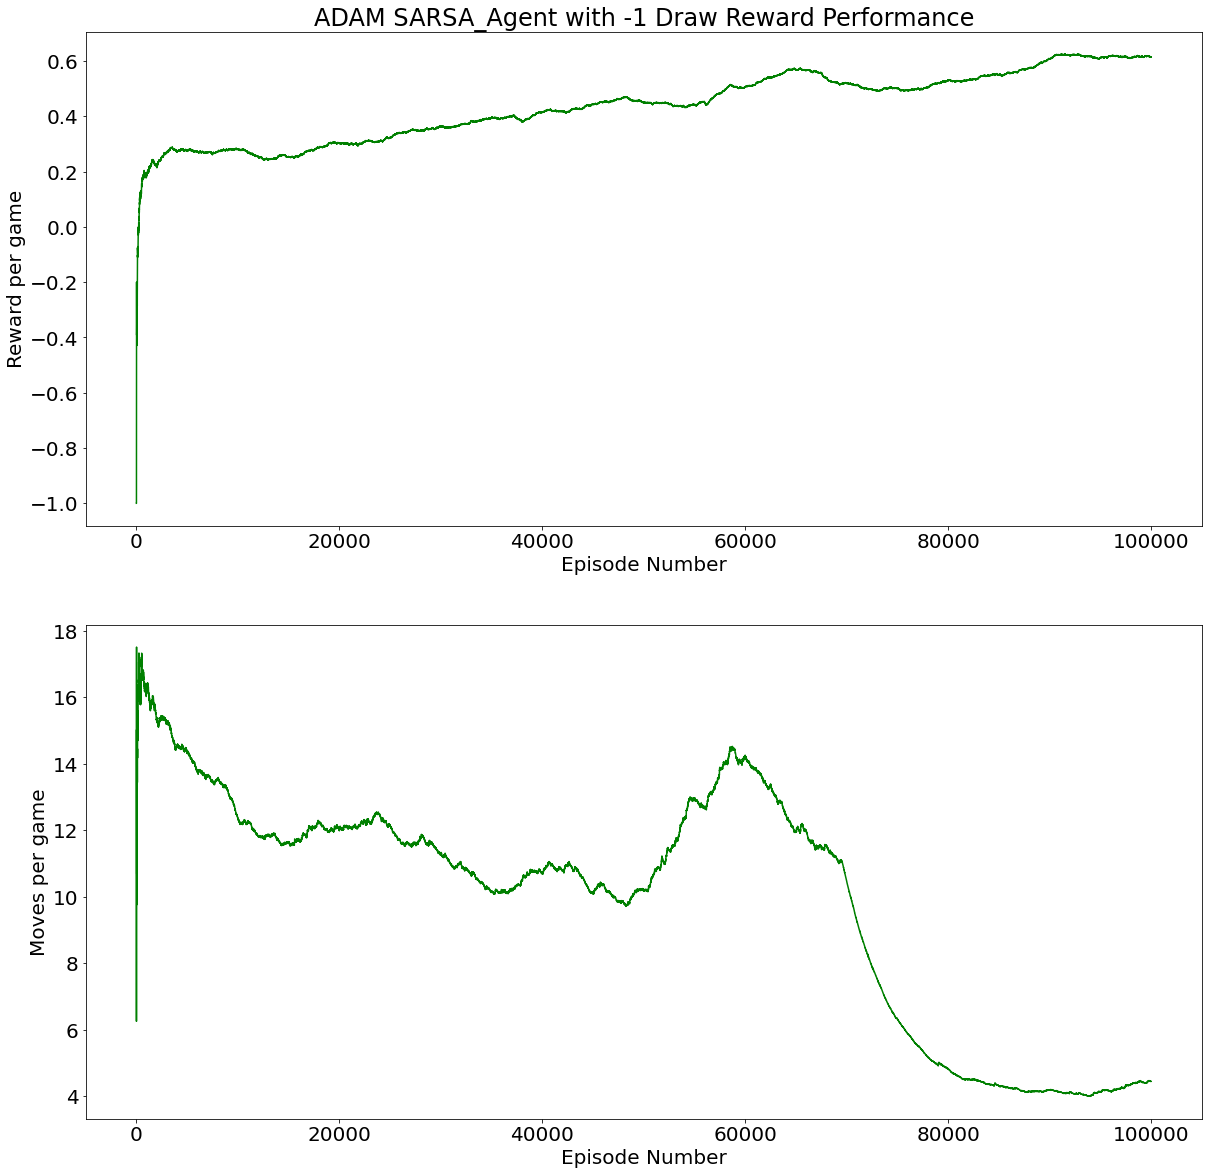

In [20]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 20})

## PLOT THE REWARD PER EPISODE AS TRAINING PROGRESSES
R_ema_SARSA_ADAM = pd.DataFrame(R_save_SARSA_ADAM).ewm(span=N_episodes/10).mean()
fig, (ax1, ax2)=plt.subplots(2,1)
ax1.title.set_text('ADAM SARSA_Agent with -1 Draw Reward Performance')
ax1.plot(R_ema_SARSA_ADAM, 'g')
ax1.set(xlabel='Episode Number', ylabel='Reward per game')

## PLOT THE NUMBER OF MOVES PER EPISODE AS TRAINING PROGRESSES
Moves_ema_SARSA_ADAM = pd.DataFrame(N_moves_save_SARSA_ADAM).ewm(span=N_episodes/10).mean()
ax2.plot(Moves_ema_SARSA_ADAM, 'g')
ax2.set(xlabel='Episode Number', ylabel='Moves per game')
plt.show()

## Varying beta for SARSA

  0%|          | 6/100000 [00:00<34:22, 48.47it/s]

SARSA Agent with beta: 1e-05  
Average reward: 0.36664 
Ave # of steps:  19.56304 
Draw %: 31.668 
Checkmate %: 68.332


  0%|          | 6/100000 [00:00<34:15, 48.66it/s]

SARSA Agent with beta: 5e-05  
Average reward: 0.50888 
Ave # of steps:  31.14282 
Draw %: 24.556 
Checkmate %: 75.444


100%|██████████| 100000/100000 [38:25<00:00, 43.37it/s] 


SARSA Agent with beta: 0.0001  
Average reward: 0.57584 
Ave # of steps:  32.94545 
Draw %: 21.208 
Checkmate %: 78.792


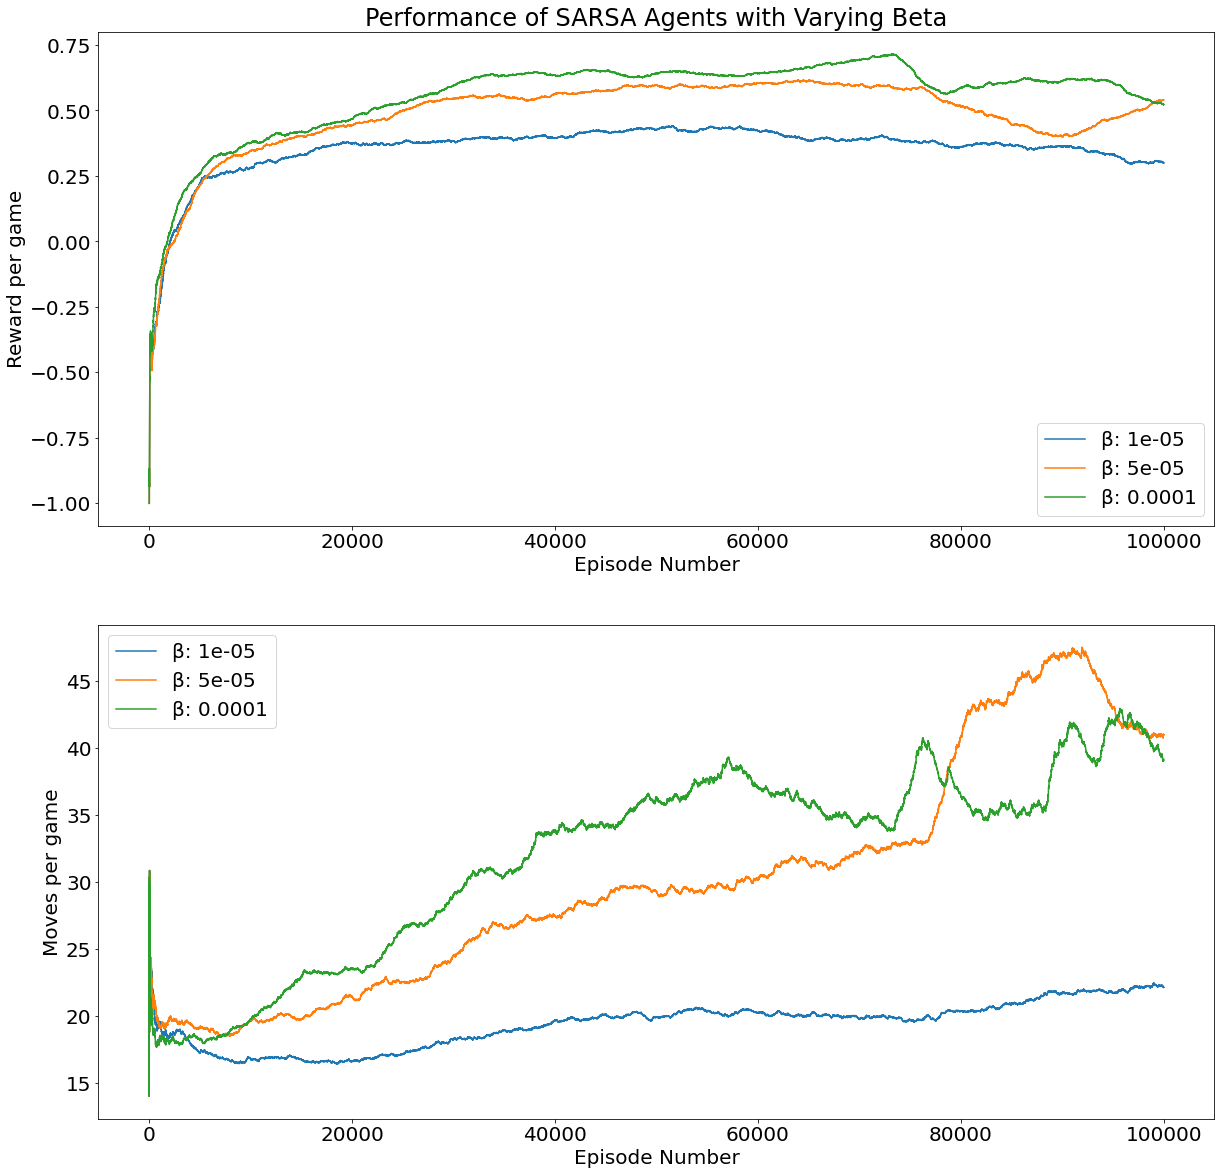

In [21]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2)=plt.subplots(2,1)
ax1.title.set_text('Performance of SARSA Agents with Varying Beta')
ax1.set(xlabel='Episode Number', ylabel='Reward per game')
ax2.set(xlabel='Episode Number', ylabel='Moves per game')

for beta in [0.00001, 0.00005, 0.0001]:
    #Set random seed to 2022 for reproducibility
    np.random.seed(2022)

    S,X,allowed_a=env.Initialise_game()
    N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

    N_in=np.shape(X)[0]    ## INPUT SIZE
    N_h=200                ## NUMBER OF HIDDEN NODES

    # HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

    epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
    gamma = 0.85        # THE DISCOUNT FACTOR
    eta = 0.0035        # THE LEARNING RATE

    N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

    # INITALISE THE NEURAL NETWORK...

    #Normalized Xavier Init: (sqrt(6.0) / sqrt(n_rows + n_cols))
    W1 = np.random.normal(0, scale=np.sqrt(6/(N_h + N_in)), size=(N_h, N_in))
    W2 = np.random.normal(0, scale=np.sqrt(6/(N_a + N_h)), size=(N_a, N_h))

    # Initialize the biases
    bias_W1 = np.zeros((N_h,))
    bias_W2 = np.zeros((N_a,))

    # SAVING VARIABLES
    R_save_SARSA_beta = np.zeros([N_episodes, 1])
    N_moves_save_SARSA_beta = np.zeros([N_episodes, 1])
    Draw_save_SARSA_beta = np.zeros([N_episodes, 1])
    Checkmate_save_SARSA_beta = np.zeros([N_episodes, 1])

    for n in tqdm(range(N_episodes)):

        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

        S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME

        while Done==0:                           ## START THE EPISODE

            # Find the Qvalues corresponding to that state
            # Neural activation: input layer -> hidden layer
            h1 = np.dot(W1,X)+bias_W1

            # Apply the sigmoid function
            x1 = 1/(1+np.exp(-h1))

            # Neural activation: hidden layer -> output layer
            h2 = np.dot(W2,x1)+bias_W2

            # Apply the sigmoid function
            Qvalues = 1/(1+np.exp(-h2))

            # Make an action
            action = EpsilonGreedy_Policy(Qvalues, allowed_a.reshape(-1), epsilon_f)

            S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)


            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done==1:
                if R==1:
                    Checkmate_save_SARSA_beta[n] = np.copy(1)
                    Draw_save_SARSA_beta[n] = np.copy(0)
                else:
                    Checkmate_save_SARSA_beta[n] = np.copy(0)
                    Draw_save_SARSA_beta[n] = np.copy(1)

                R_save_SARSA_beta[n] = np.copy(R)
                N_moves_save_SARSA_beta[n] = np.copy(i)

                # Compute the error signal
                e_n = R - Qvalues[action]

                # Backpropagation: output layer -> hidden layer
                delta2 = Qvalues*(1-Qvalues) * e_n
                dW2 = np.outer(delta2, x1)

                dbias_W2 = delta2

                # Backpropagation: hidden layer -> input layer
                delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
                dW1 = np.outer(delta1, X)

                dbias_W1 = delta1

                #Update W1 and W2 only for the action taken
                W2[action, :] += eta*dW2[action, :]
                W1[action, :] += eta*dW1[action, :]
                bias_W2[action] += eta*dbias_W2[action]
                bias_W1[action] += eta*dbias_W1[action]

                break;


            # IF THE EPISODE IS NOT OVER...
            else:

                # Neural activation: input layer -> hidden layer
                h1 = np.matmul(W1, X_next)+bias_W1

                # Apply the sigmoid function
                x1 = 1/(1+np.exp(-h1))

                # Neural activation: hidden layer -> output layer
                h2 = np.dot(W2,x1)+bias_W2

                # Apply the sigmoid function
                next_Qvalues = 1/(1+np.exp(-h2))

                next_action = EpsilonGreedy_Policy(next_Qvalues, allowed_a_next.reshape(-1), epsilon_f)

                # Compute the error signal
                e_n = (R + gamma * next_Qvalues[next_action] - Qvalues[action])

                # Backpropagation: output layer -> hidden layer
                delta2 = Qvalues*(1-Qvalues) * e_n
                dW2 = np.outer(delta2, x1)

                dbias_W2 = delta2

                # Backpropagation: hidden layer -> input layer
                delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
                dW1 = np.outer(delta1, X)

                dbias_W1 = delta1

                #Update W1 and W2; b1 and b2 only for the action taken
                W2[action, :] += eta*dW2[action, :]
                W1[action, :] += eta*dW1[action, :]
                bias_W2[action] += eta*dbias_W2[action]
                bias_W1[action] += eta*dbias_W1 [action]


                # NEXT STATE AND CO. BECOME ACTUAL STATE...     
                S = np.copy(S_next)
                X = np.copy(X_next)
                allowed_a = np.copy(allowed_a_next)


            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    ## PLOT THE REWARD PER EPISODE AS TRAINING PROGRESSES
    R_ema_SARSA_beta = pd.DataFrame(R_save_SARSA_beta).ewm(span=N_episodes/10).mean()
    ax1.plot(R_ema_SARSA_beta, label="β: {}".format(beta))


    ## PLOT THE NUMBER OF MOVES PER EPISODE AS TRAINING PROGRESSES
    Moves_ema_SARSA_beta = pd.DataFrame(N_moves_save_SARSA_beta).ewm(span=N_episodes/10).mean()
    ax2.plot(Moves_ema_SARSA_beta, label="β: {}".format(beta)) 
    print('SARSA Agent with beta: {} '.format(beta),'\nAverage reward:', np.mean(R_save_SARSA_beta),'\nAve # of steps: ', np.mean(N_moves_save_SARSA_beta), '\nDraw %:', 100*np.sum(Draw_save_SARSA_beta)/N_episodes, '\nCheckmate %:', 100*np.sum(Checkmate_save_SARSA_beta)/N_episodes)

ax1.legend() 
ax2.legend()
plt.show()

## Varying gamma for SARSA

  0%|          | 6/100000 [00:00<34:32, 48.25it/s]

SARSA Agent with gamma: 0.5  
Average reward: 0.49394 
Ave # of steps:  29.19442 
Draw %: 25.303 
Checkmate %: 74.697


  0%|          | 7/100000 [00:00<25:26, 65.52it/s]

SARSA Agent with gamma: 0.85  
Average reward: 0.50888 
Ave # of steps:  31.14282 
Draw %: 24.556 
Checkmate %: 75.444


100%|██████████| 100000/100000 [31:47<00:00, 52.43it/s]


SARSA Agent with gamma: 0.95  
Average reward: 0.50116 
Ave # of steps:  26.82057 
Draw %: 24.942 
Checkmate %: 75.058


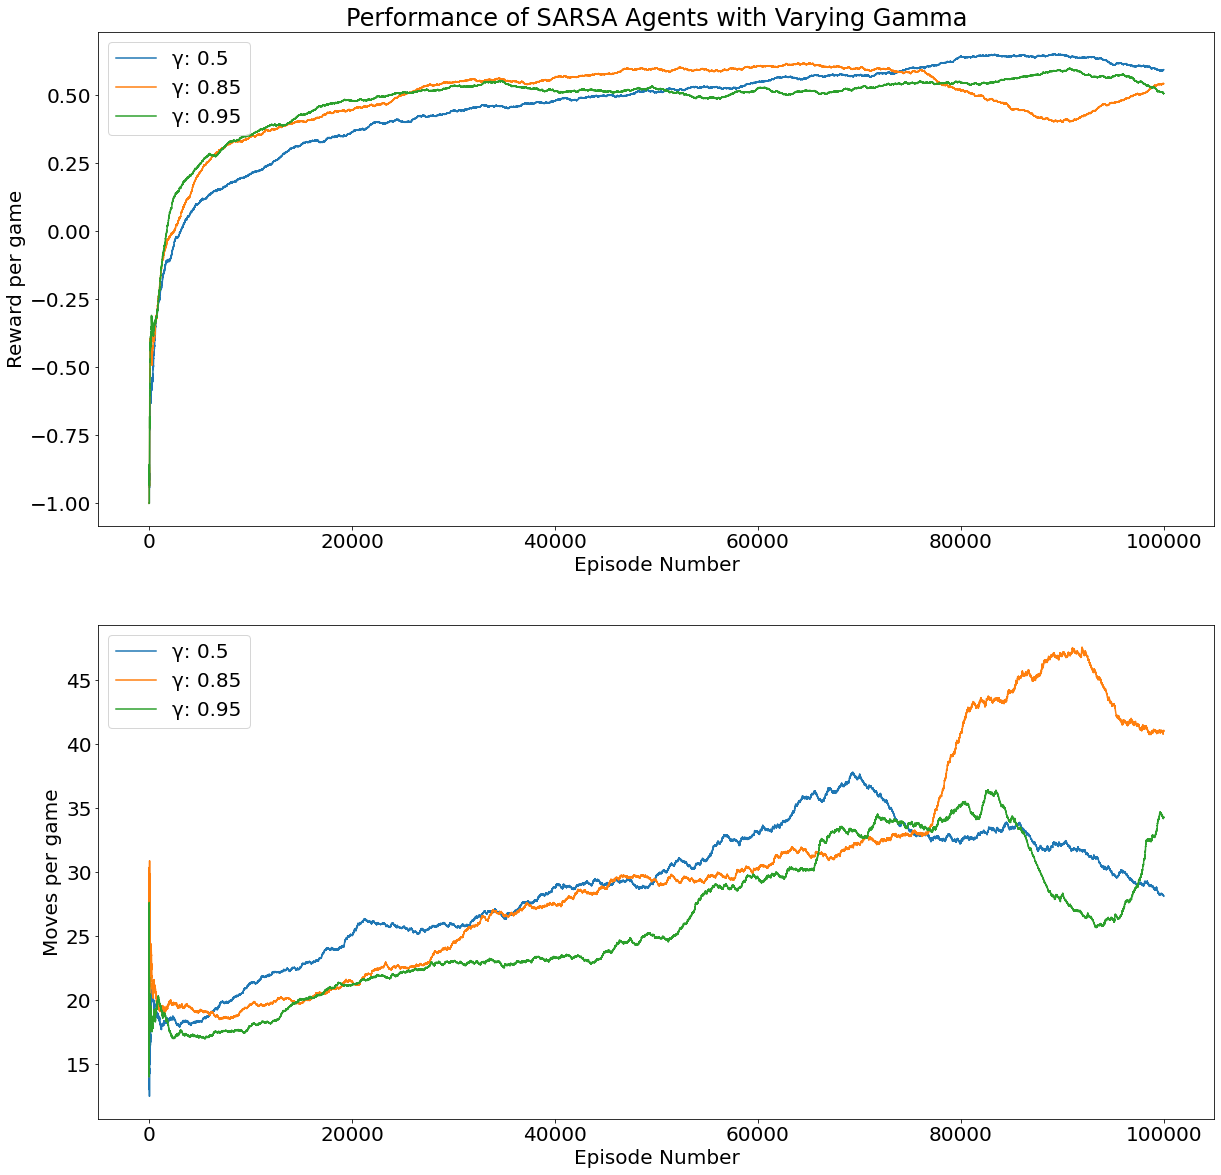

In [22]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2)=plt.subplots(2,1)
ax1.title.set_text('Performance of SARSA Agents with Varying Gamma')
ax1.set(xlabel='Episode Number', ylabel='Reward per game')
ax2.set(xlabel='Episode Number', ylabel='Moves per game')

for gamma in [0.5, 0.85, 0.95]:
    #Set random seed to 2022 for reproducibility
    np.random.seed(2022)

    S,X,allowed_a=env.Initialise_game()
    N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

    N_in=np.shape(X)[0]    ## INPUT SIZE
    N_h=200                ## NUMBER OF HIDDEN NODES

    # HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

    epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
    beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
    eta = 0.0035        # THE LEARNING RATE

    N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

    # INITALISE THE NEURAL NETWORK...

    #Normalized Xavier Init: (sqrt(6.0) / sqrt(n_rows + n_cols))
    W1 = np.random.normal(0, scale=np.sqrt(6/(N_h + N_in)), size=(N_h, N_in))
    W2 = np.random.normal(0, scale=np.sqrt(6/(N_a + N_h)), size=(N_a, N_h))

    # Initialize the biases
    bias_W1 = np.zeros((N_h,))
    bias_W2 = np.zeros((N_a,))

    # SAVING VARIABLES
    R_save_SARSA_gamma = np.zeros([N_episodes, 1])
    N_moves_save_SARSA_gamma = np.zeros([N_episodes, 1])
    Draw_save_SARSA_gamma = np.zeros([N_episodes, 1])
    Checkmate_save_SARSA_gamma = np.zeros([N_episodes, 1])

    for n in tqdm(range(N_episodes)):

        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

        S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME

        while Done==0:                           ## START THE EPISODE

            # Find the Qvalues corresponding to that state
            # Neural activation: input layer -> hidden layer
            h1 = np.dot(W1,X)+bias_W1

            # Apply the sigmoid function
            x1 = 1/(1+np.exp(-h1))

            # Neural activation: hidden layer -> output layer
            h2 = np.dot(W2,x1)+bias_W2

            # Apply the sigmoid function
            Qvalues = 1/(1+np.exp(-h2))

            # Make an action
            action = EpsilonGreedy_Policy(Qvalues, allowed_a.reshape(-1), epsilon_f)

            S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)


            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done==1:
                if R==1:
                    Checkmate_save_SARSA_gamma[n] = np.copy(1)
                    Draw_save_SARSA_gamma[n] = np.copy(0)
                else:
                    Checkmate_save_SARSA_gamma[n] = np.copy(0)
                    Draw_save_SARSA_gamma[n] = np.copy(1)

                R_save_SARSA_gamma[n] = np.copy(R)
                N_moves_save_SARSA_gamma[n] = np.copy(i)

                # Compute the error signal
                e_n = R - Qvalues[action]

                # Backpropagation: output layer -> hidden layer
                delta2 = Qvalues*(1-Qvalues) * e_n
                dW2 = np.outer(delta2, x1)

                dbias_W2 = delta2

                # Backpropagation: hidden layer -> input layer
                delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
                dW1 = np.outer(delta1, X)

                dbias_W1 = delta1

                #Update W1 and W2 only for the action taken
                W2[action, :] += eta*dW2[action, :]
                W1[action, :] += eta*dW1[action, :]
                bias_W2[action] += eta*dbias_W2[action]
                bias_W1[action] += eta*dbias_W1[action]

                break;


            # IF THE EPISODE IS NOT OVER...
            else:

                # Neural activation: input layer -> hidden layer
                h1 = np.matmul(W1, X_next)+bias_W1

                # Apply the sigmoid function
                x1 = 1/(1+np.exp(-h1))

                # Neural activation: hidden layer -> output layer
                h2 = np.dot(W2,x1)+bias_W2

                # Apply the sigmoid function
                next_Qvalues = 1/(1+np.exp(-h2))

                next_action = EpsilonGreedy_Policy(next_Qvalues, allowed_a_next.reshape(-1), epsilon_f)

                # Compute the error signal
                e_n = (R + gamma * next_Qvalues[next_action] - Qvalues[action])

                # Backpropagation: output layer -> hidden layer
                delta2 = Qvalues*(1-Qvalues) * e_n
                dW2 = np.outer(delta2, x1)

                dbias_W2 = delta2

                # Backpropagation: hidden layer -> input layer
                delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
                dW1 = np.outer(delta1, X)

                dbias_W1 = delta1

                #Update W1 and W2; b1 and b2 only for the action taken
                W2[action, :] += eta*dW2[action, :]
                W1[action, :] += eta*dW1[action, :]
                bias_W2[action] += eta*dbias_W2[action]
                bias_W1[action] += eta*dbias_W1 [action]


                # NEXT STATE AND CO. BECOME ACTUAL STATE...     
                S = np.copy(S_next)
                X = np.copy(X_next)
                allowed_a = np.copy(allowed_a_next)


            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    ## PLOT THE REWARD PER EPISODE AS TRAINING PROGRESSES
    R_ema_SARSA_gamma = pd.DataFrame(R_save_SARSA_gamma).ewm(span=N_episodes/10).mean()
    ax1.plot(R_ema_SARSA_gamma, label="γ: {}".format(gamma))


    ## PLOT THE NUMBER OF MOVES PER EPISODE AS TRAINING PROGRESSES
    Moves_ema_SARSA_gamma = pd.DataFrame(N_moves_save_SARSA_gamma).ewm(span=N_episodes/10).mean()
    ax2.plot(Moves_ema_SARSA_gamma, label="γ: {}".format(gamma)) 
    print('SARSA Agent with gamma: {} '.format(gamma),'\nAverage reward:', np.mean(R_save_SARSA_gamma),'\nAve # of steps: ', np.mean(N_moves_save_SARSA_gamma), '\nDraw %:', 100*np.sum(Draw_save_SARSA_gamma)/N_episodes, '\nCheckmate %:', 100*np.sum(Checkmate_save_SARSA_gamma)/N_episodes)

ax1.legend() 
ax2.legend()
plt.show()

# Q-LEARNING

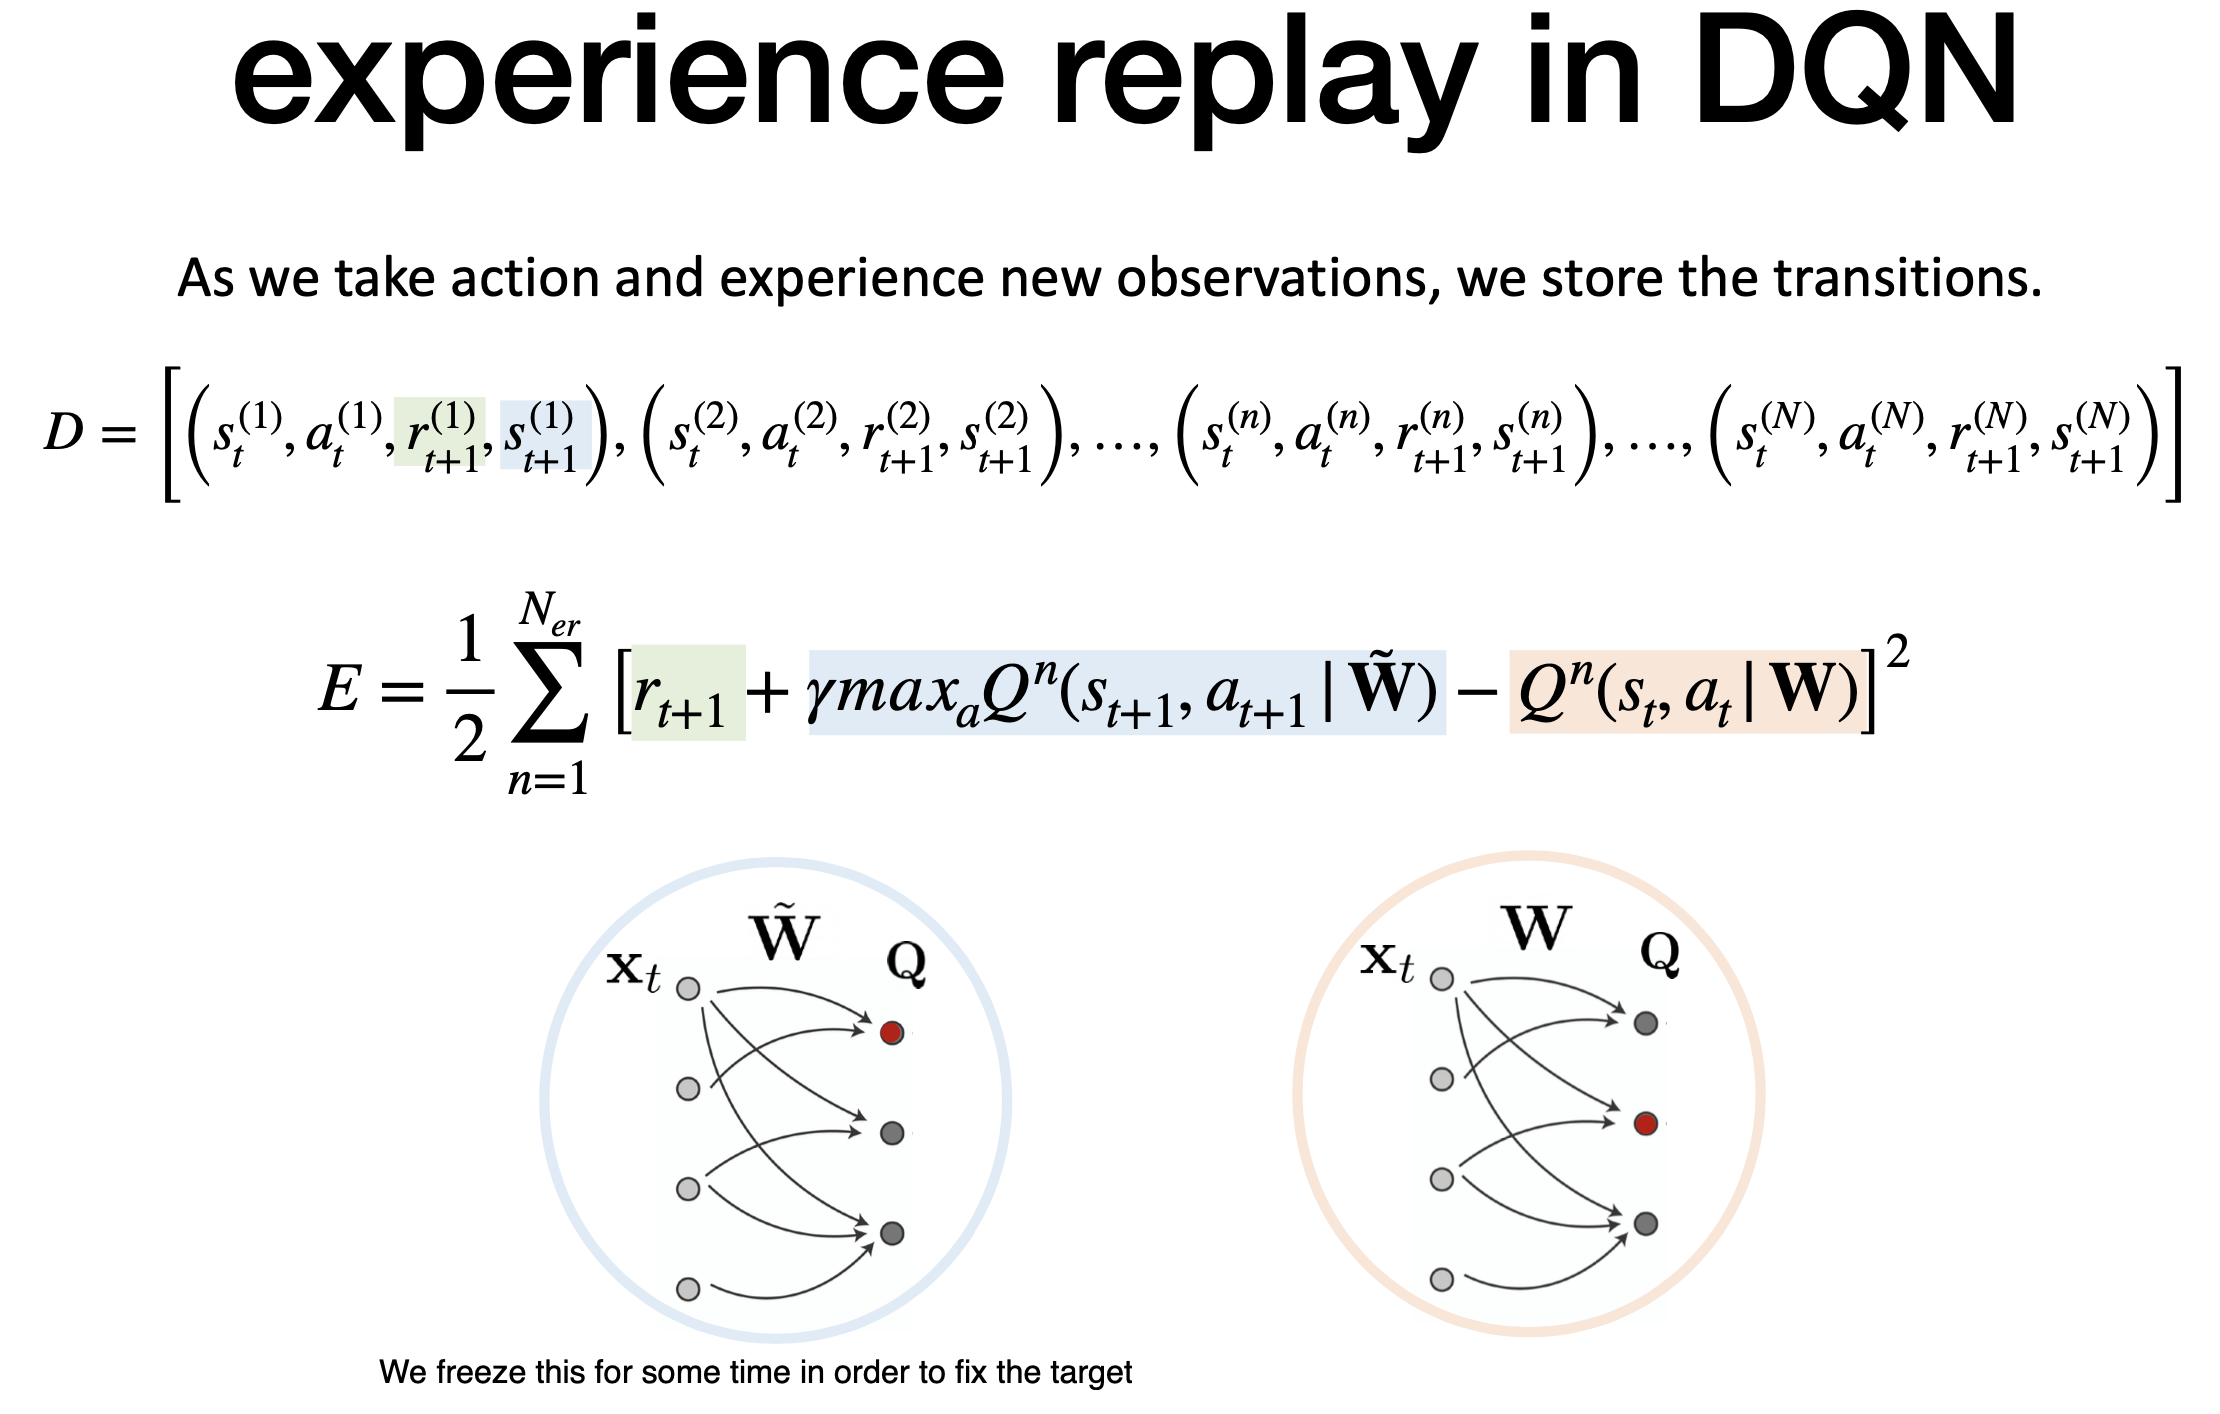

### Using the ReLU activation function, the backpropagation scheme will look like:
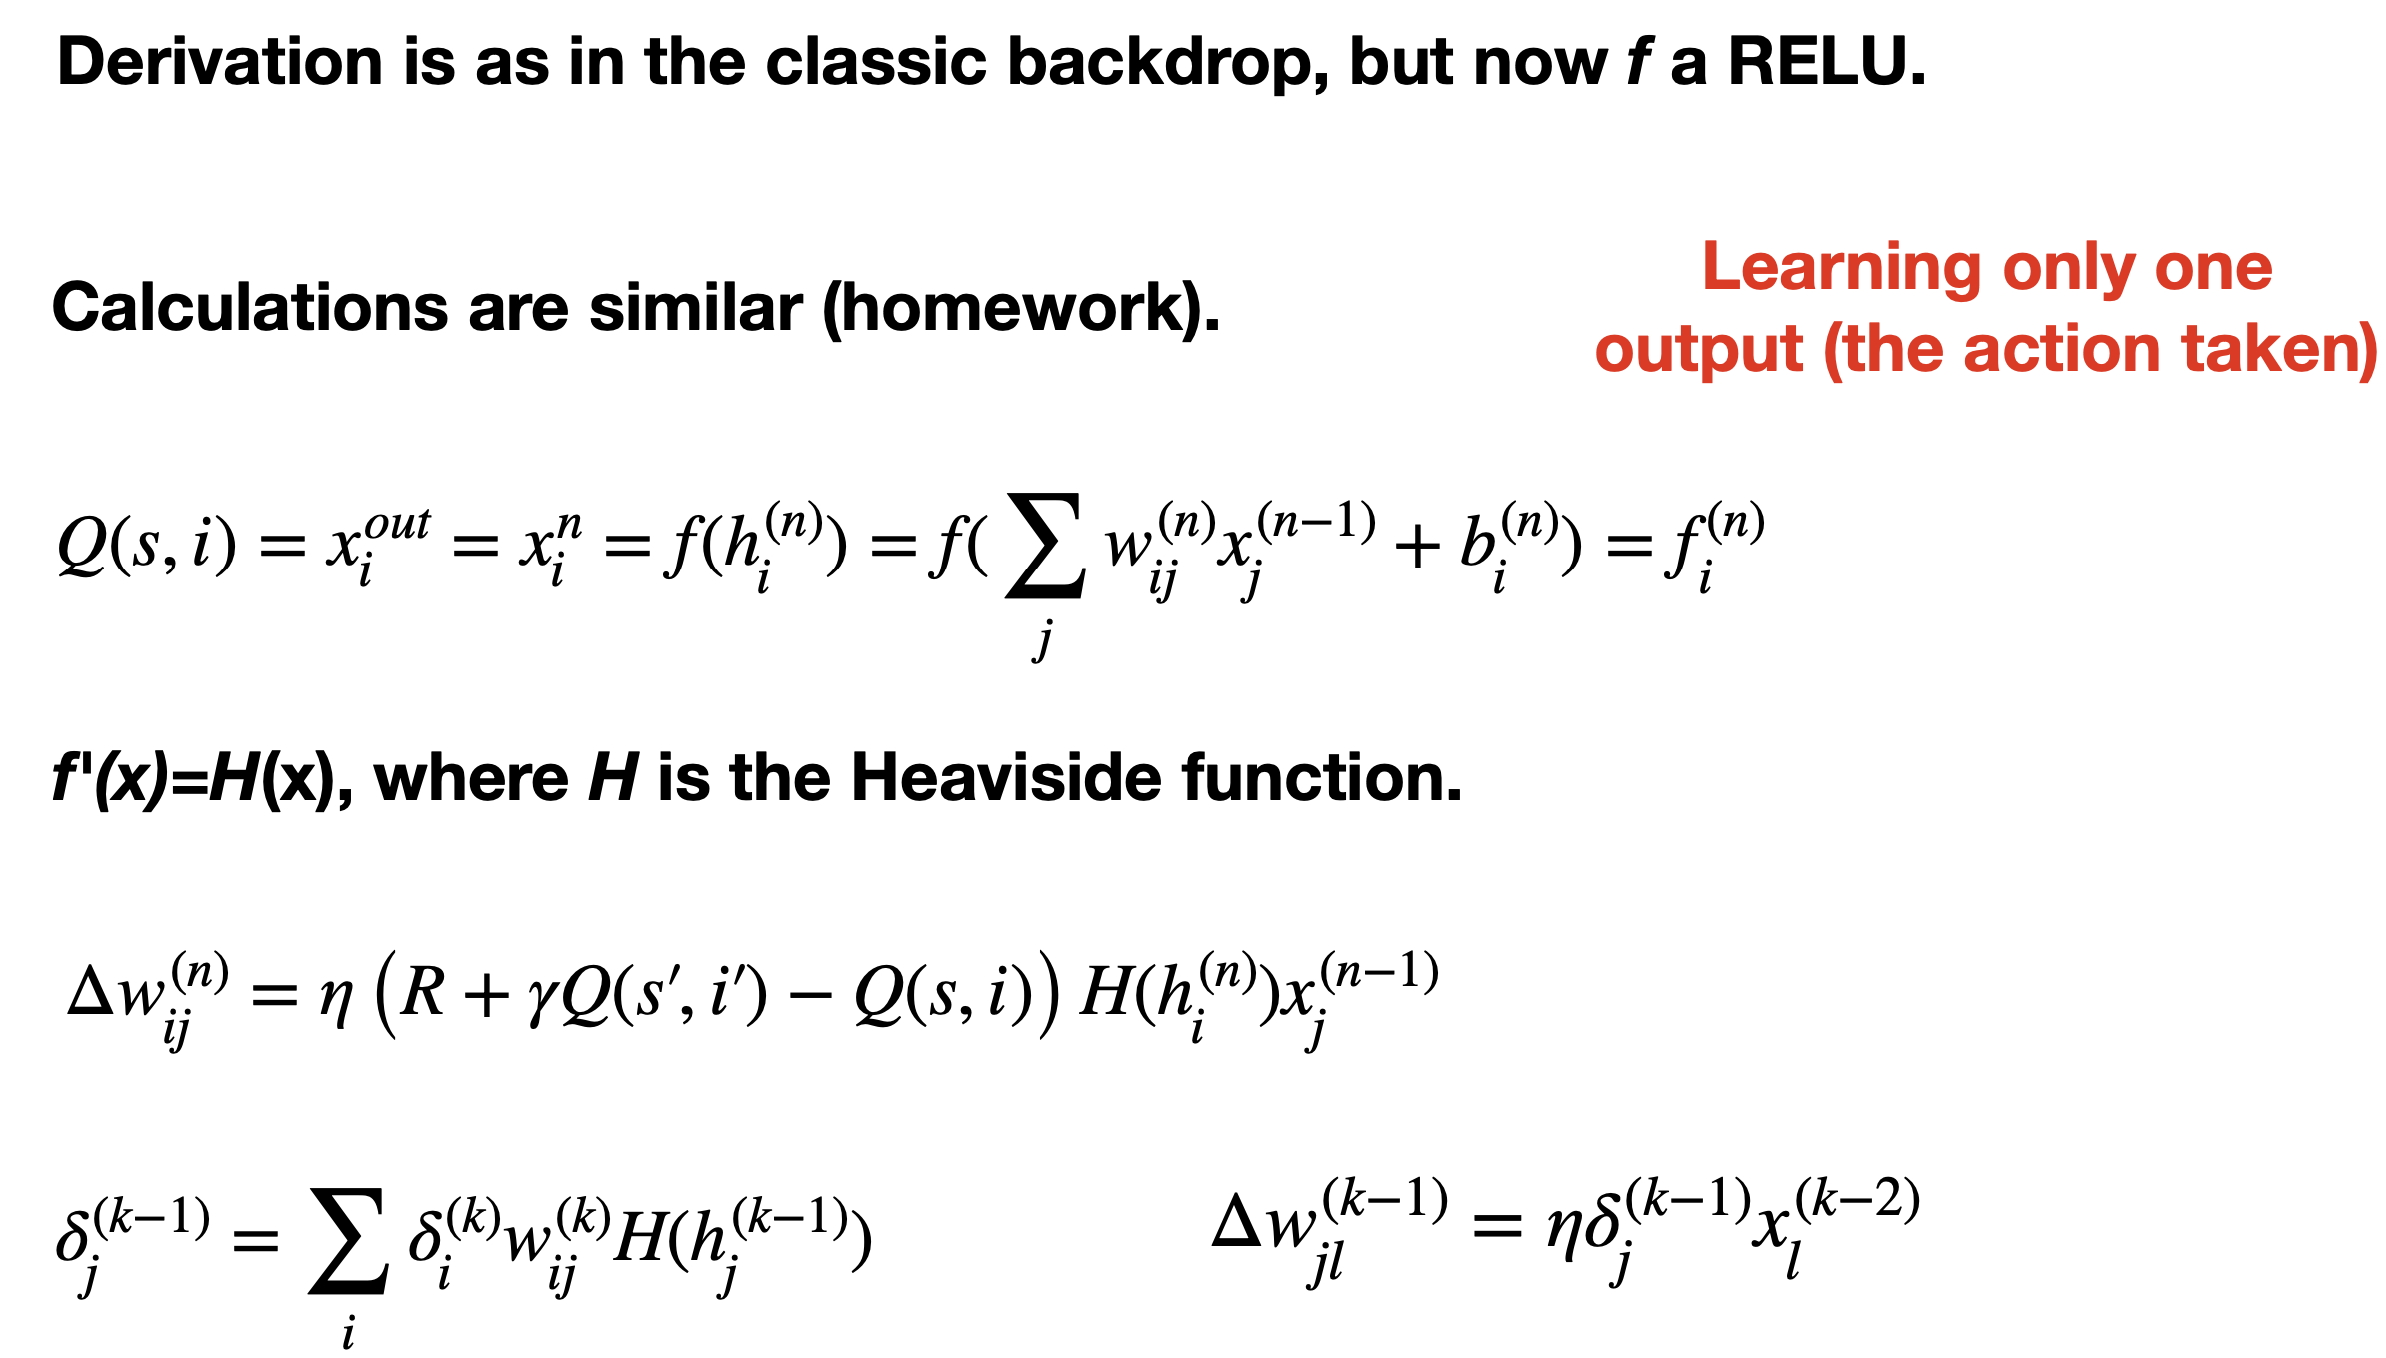

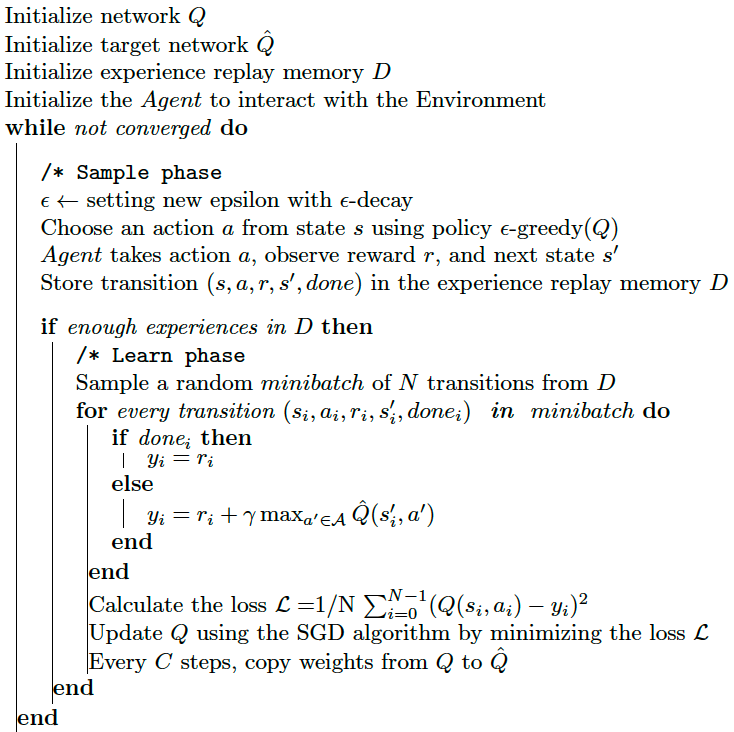

## DDQN with draw reward R=-1, "Nonvectorized" SGD implementation¶

In [23]:
# INITIALISE THE ENVIRONMENT, PARAMETERS, AND THE NEURAL NETWORK 
env=Chess_env_with_draw_punishment.Chess_Env(size_board)
np.random.seed(2022)

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

batch_size = 32
N_experiences = 10000   #NUMBER OF EXPERIENCES WE KEEP IN THE REPLAY BUFFER
N_episodes = 100000

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.00035       # THE LEARNING RATE
epsilon_f = epsilon_0   ## DECAYING EPSILON initialized first as EPSILON_0


#Normalized Xavier Init: (sqrt(6.0) / sqrt(n_rows + n_cols))
W1 = np.random.normal(0, scale=np.sqrt(6/(N_h + N_in)), size=(N_h, N_in))
W2 = np.random.normal(0, scale=np.sqrt(6/(N_a + N_h)), size=(N_a, N_h))

W1_target = W1.copy()
W2_target = W2.copy()

# Initialize the biases
bias_W1 = np.zeros((N_h,))
bias_W2 = np.zeros((N_a,))

bias_W1_target = bias_W1.copy()
bias_W2_target = bias_W2.copy()


# SAVING VARIABLES
R_save_DDQN = np.zeros([N_episodes, 1])
N_moves_save_DDQN = np.zeros([N_episodes, 1])
Draw_save_DDQN = np.zeros([N_episodes, 1])
Checkmate_save_DDQN = np.zeros([N_episodes, 1])

In [24]:
min_buffer_size= 100     #Minimum replay buffer size such that there are enough experiences for training to start
D = collections.deque(maxlen = N_experiences)  #initialize replay buffer as a deque with maximum length N_experiences
counter_to_copy = 0    #COUNTER FOR time_to_copy
time_to_copy = 200    #determines after how many episodes we copy the online network to the target network

episodes_elapsed = 0   #COUNTER FOR NUMBER OF EPISODES
S, X, allowed_a = env.Initialise_game()
i = 0                                    # COUNTER FOR NUMBER OF ACTIONS
pbar = tqdm(total = N_episodes)

while episodes_elapsed < N_episodes:
                            
    # Find the Qvalues corresponding to that state
    # Neural activation: input layer -> hidden layer
    h1 = np.dot(W1,X)+bias_W1

    # Apply the sigmoid function
    x1 = 1/(1+np.exp(-h1))

    # Neural activation: hidden layer -> output layer
    h2 = np.dot(W2,x1)+bias_W2

    # Apply the sigmoid function
    Qvalues = 1/(1+np.exp(-h2))

    # Make an action
    action = EpsilonGreedy_Policy(Qvalues, allowed_a.reshape(-1), epsilon_f)

    S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)
    
    #Store (s,a,r,s',Done) into buffer
    D.append((X, action, R, X_next, Done))  
    
    # NEXT STATE AND CO. BECOME ACTUAL STATE...     
    S = np.copy(S_next)
    X = np.copy(X_next)
    allowed_a = np.copy(allowed_a_next)

    i+=1    #increase number of actions taken by 1
    
    if Done:
        if R==1:   #if checkmate
            Checkmate_save_DDQN[episodes_elapsed] = np.copy(1)
            Draw_save_DDQN[episodes_elapsed] = np.copy(0)
        else:     #if draw
            Checkmate_save_DDQN[episodes_elapsed] = np.copy(0)
            Draw_save_DDQN[episodes_elapsed] = np.copy(1)

        R_save_DDQN[episodes_elapsed] = np.copy(R)
        N_moves_save_DDQN[episodes_elapsed] = np.copy(i)
        
        episodes_elapsed += 1
        S, X, allowed_a = env.Initialise_game()
        i=0
        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        
        pbar.update(1)
    if len(D)<min_buffer_size:
        continue
       
    #This code runs after the buffer has enough samples to start training
    counter_to_copy += 1

    #Sample a random minibatch of experiences from D
    indices = np.random.randint(0, len(D), size=batch_size)    
    sampled_minibatch = [D[i] for i in indices]

    for (X, action, R, X_next, Done) in sampled_minibatch:
        #Compute the Q values
        h1 = np.dot(W1,X)+bias_W1

        # Apply the sigmoid function
        x1 = 1/(1+np.exp(-h1))

        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2

        # Apply the sigmoid function
        Qvalues = 1/(1+np.exp(-h2))

        if Done:

            # Compute the error signal
            e_n = R - Qvalues[action]

            # Backpropagation: output layer -> hidden layer
            delta2 = Qvalues*(1-Qvalues) * e_n
            dW2 = np.outer(delta2, x1)

            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1, X)

            dbias_W1 = delta1

            #Update W1 and W2; b1 and b2, only for the action taken SGD
            W2[action, :] += eta*dW2[action, :]
            W1[action, :] += eta*dW1[action, :]
            bias_W2[action] += eta*dbias_W2[action]
            bias_W1[action] += eta*dbias_W1[action]
            
#           #Update W1 and W2; b1 and b2 only for the action taken ADAM
#           W2[action, :] += eta * Adam_W2.Compute(dW2)[action, :]
#           W1[action, :] += eta * Adam_W1.Compute(dW1)[action, :]
#           bias_W2[action] += eta * Adam_b2.Compute(dbias_W2)[action]
#           bias_W1[action] += eta * Adam_b1.Compute(dbias_W1)[action]

        else: #if not done
            #Calculate Q_target using X_next
            h1_next = np.dot(W1_target,X_next)+bias_W1_target

            # Apply the sigmoid function
            x1_next = 1/(1+np.exp(-h1_next))

            # Neural activation: hidden layer -> output layer
            h2_next = np.dot(W2_target,x1)+bias_W2_target

            # Apply the sigmoid function
            Qvalues_target = 1/(1+np.exp(-h2_next))

            # Compute the error signal for Q_target using max
            e_n = R + gamma * np.max(Qvalues_target) - Qvalues[action]

            # Backpropagation: output layer -> hidden layer 
            #Realize: we use the online Q network's x1, x2 not the target's (x1_next vs.)
            delta2 = Qvalues*(1-Qvalues) * e_n
            dW2 = np.outer(delta2, x1)

            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = x1*(1-x1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1, X)

            dbias_W1 = delta1
            #Update W1 and W2; b1 and b2 only for the action taken SGD
            W2[action, :] += eta*dW2[action, :]
            W1[action, :] += eta*dW1[action, :]
            bias_W2[action] += eta*dbias_W2[action]
            bias_W1[action] += eta*dbias_W1 [action]
            
#           #Update W1 and W2; b1 and b2 only for the action taken ADAM
#           W2[action, :] += eta * Adam_W2.Compute(dW2)[action, :]
#           W1[action, :] += eta * Adam_W1.Compute(dW1)[action, :]
#           bias_W2[action] += eta * Adam_b2.Compute(dbias_W2)[action]
#           bias_W1[action] += eta * Adam_b1.Compute(dbias_W1)[action]

        if counter_to_copy % time_to_copy ==0:

            W1_target = W1.copy()
            W2_target = W2.copy()

            bias_W1_target = bias_W1.copy()
            bias_W2_target = bias_W2.copy()
pbar.close()

100%|██████████| 100000/100000 [3:05:24<00:00,  8.99it/s]  


In [25]:
print('DDQN Agent with -1 draw reward SGD','\nAverage reward:', np.mean(R_save_DDQN),'\nAve # of steps: ', np.mean(N_moves_save_DDQN), '\nDraw %:', np.sum(Draw_save_DDQN)/N_episodes, '\nCheckmate %:', np.sum(Checkmate_save_DDQN)/N_episodes)

DDQN Agent with -1 draw reward SGD 
Average reward: 0.51496 
Ave # of steps:  32.13215 
Draw %: 0.24252 
Checkmate %: 0.75748


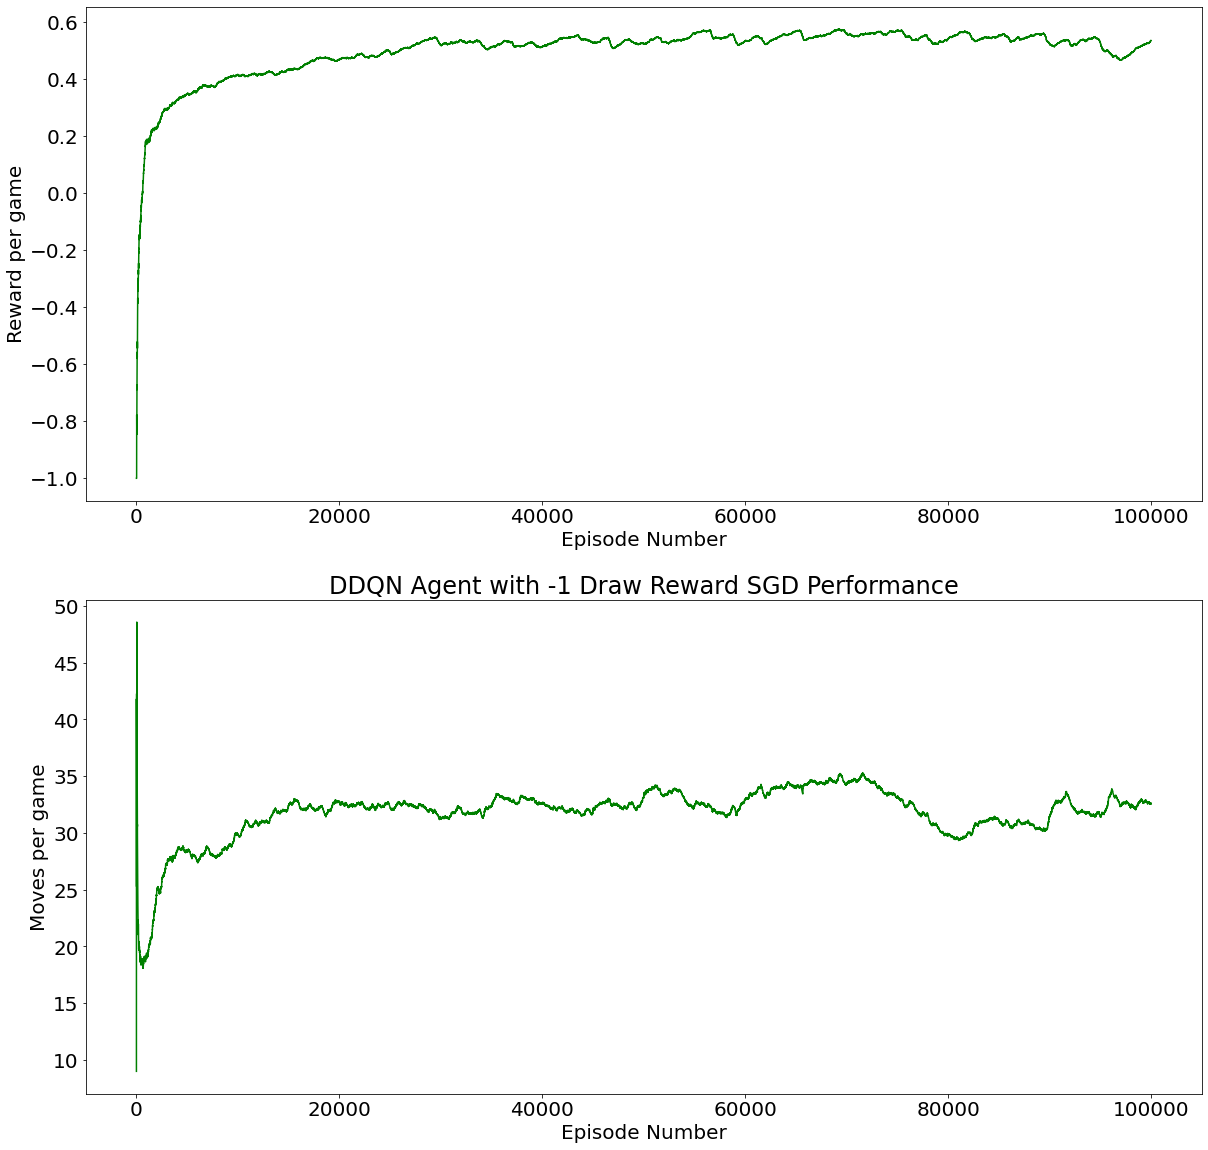

In [26]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 20})

## PLOT THE REWARD PER EPISODE AS TRAINING PROGRESSES
R_ema_DDQN = pd.DataFrame(R_save_DDQN).ewm(span=N_episodes/10).mean()
fig, (ax1, ax2)=plt.subplots(2,1)
ax1.plot(R_ema_DDQN, 'g')
ax1.set(xlabel='Episode Number', ylabel='Reward per game')

## PLOT THE NUMBER OF MOVES PER EPISODE AS TRAINING PROGRESSES
Moves_ema_DDQN = pd.DataFrame(N_moves_save_DDQN).ewm(span=N_episodes/10).mean()
ax2.plot(Moves_ema_DDQN, 'g')
ax2.set(xlabel='Episode Number', ylabel='Moves per game')
plt.title('DDQN Agent with -1 Draw Reward SGD Performance')
plt.show()

### DDQN with draw reward R=-1 utilizing "Vectorized" Minibatch implementation
This implementation will reduce training time significantly

In [27]:
# INITIALISE THE ENVIRONMENT, PARAMETERS, AND THE NEURAL NETWORK 
env=Chess_env_with_draw_punishment.Chess_Env(size_board)
np.random.seed(2022)

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

batch_size = 32
N_experiences = 10000   #NUMBER OF EXPERIENCES WE KEEP IN THE REPLAY BUFFER
N_episodes = 100000

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.01       # THE LEARNING RATE
epsilon_f = epsilon_0   ## DECAYING EPSILON initialized first as EPSILON_0


#Normalized Xavier Init: (sqrt(6.0) / sqrt(n_rows + n_cols))
W1 = np.random.normal(0, scale=np.sqrt(6/(N_h + N_in)), size=(N_h, N_in))
W2 = np.random.normal(0, scale=np.sqrt(6/(N_a + N_h)), size=(N_a, N_h))

W1_target = W1.copy()
W2_target = W2.copy()

# Initialize the biases
bias_W1 = np.zeros((N_h,))
bias_W2 = np.zeros((N_a,))

bias_W1_target = bias_W1.copy()
bias_W2_target = bias_W2.copy()


# SAVING VARIABLES
R_save_DDQN_V = np.zeros([N_episodes, 1])
N_moves_save_DDQN_V = np.zeros([N_episodes, 1])
Draw_save_DDQN_V = np.zeros([N_episodes, 1])
Checkmate_save_DDQN_V = np.zeros([N_episodes, 1])

In [28]:
min_buffer_size= 100
D = collections.deque(maxlen = N_experiences)
counter_to_copy = 0
time_to_copy = 200

episodes_elapsed = 0
S, X, allowed_a = env.Initialise_game()
i = 0                                    ## COUNTER FOR NUMBER OF ACTIONS
pbar = tqdm(total = N_episodes)

while episodes_elapsed < N_episodes:
                            
    # Find the Qvalues corresponding to that state
    # Neural activation: input layer -> hidden layer
    #h1 = np.dot(W1,X)+bias_W1
    h1 = np.dot(W1,X) + bias_W1
    # Apply the sigmoid function
    x1 = 1/(1+np.exp(-h1))

    # Neural activation: hidden layer -> output layer
    h2 = np.dot(W2,x1)+bias_W2

    # Apply the sigmoid function
    Qvalues = 1/(1+np.exp(-h2))

    # Make an action
    action = EpsilonGreedy_Policy(Qvalues, allowed_a.reshape(-1), epsilon_f)

    S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)
    
    #Store (s,a,r,s',Done) into buffer
    D.append((X, action, R, X_next, Done))  
    
    # NEXT STATE AND CO. BECOME ACTUAL STATE...     
    S = np.copy(S_next)
    X = np.copy(X_next)
    allowed_a = np.copy(allowed_a_next)

    i+=1
    
    if Done:
        if R==1:   #if checkmate
            Checkmate_save_DDQN_V[episodes_elapsed] = np.copy(1)
            Draw_save_DDQN_V[episodes_elapsed] = np.copy(0)
        else:     #if draw
            Checkmate_save_DDQN_V[episodes_elapsed] = np.copy(0)
            Draw_save_DDQN_V[episodes_elapsed] = np.copy(1)

        R_save_DDQN_V[episodes_elapsed] = np.copy(R)
        N_moves_save_DDQN_V[episodes_elapsed] = np.copy(i)
        
        episodes_elapsed += 1
        S, X, allowed_a = env.Initialise_game()
        i=0
        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        
        pbar.update(1)
        
    if len(D)<min_buffer_size:
        continue
       
    #This code runs after the buffer has enough samples to start training
    counter_to_copy += 1

    #Sample a random minibatch of experiences from D
    indices = np.random.randint(0, len(D), size=batch_size)    
    sampled_minibatch = [D[i] for i in indices]
    
    batch_array = np.array(sampled_minibatch, dtype=object)
    
    X_batch = np.transpose(np.stack(batch_array[:, 0]))  
    action_batch = np.array(batch_array[:, 1], dtype=int)
    R_batch = np.array(batch_array[:, 2], dtype=int)
    X_next_batch = np.transpose(np.stack(np.array(list(map(lambda row: row if len(row)>0 else np.zeros(X_batch.shape[0], dtype=int), batch_array[:, 3])), dtype=int)))
    Done_batch = np.array(batch_array[:, 4], dtype=int)


    #Compute the Q values
    h1 = np.dot(W1,X_batch) + np.tile(bias_W1, reps=[batch_size,1]).T
    # Apply the sigmoid function
    X1 = 1/(1+np.exp(-h1))
    # Neural activation: hidden layer -> output layer
    h2 = np.dot(W2,X1) + np.tile(bias_W2, reps=[batch_size,1]).T

    # Apply the sigmoid function
    Qvalues_batch = 1/(1+np.exp(-h2))

    #Calculate one-hot-encoding of the actions
    one_hot_action_batch = np.eye(32)[np.array(action_batch).reshape(-1)].T
    #Find the vector of Q values of the actions taken for each sample in the batch
    Q_taken_actions_batch = np.max(one_hot_action_batch * Qvalues_batch , axis=0)
    
    
    #Calculate Q_target using X_next_batch
    h1_next = np.dot(W1_target,X_next_batch)+np.tile(bias_W1_target, reps=[batch_size,1]).T
    # Apply the sigmoid function
    X1_next = 1/(1+np.exp(-h1_next))
    # Neural activation: hidden layer -> output layer
    h2_next = np.dot(W2_target,X1_next)+np.tile(bias_W2_target, reps=[batch_size,1]).T
    # Apply the sigmoid function
    Qvalues_target_batch = 1/(1+np.exp(-h2_next))
    
    #Calculate the error signal (combines Done=0 and Done=1 computations)
    e_n = one_hot_action_batch * (R_batch + gamma * (1-Done_batch) * np.max(Qvalues_target_batch, axis=0)  - Q_taken_actions_batch)
    #Realize: we use apply the backpropagation to the online Q network not the target network
    delta2 = e_n * Qvalues_batch * (1-Qvalues_batch)
    dbias_W2 = delta2
    dW2 = np.dot(delta2, X1.T)
    
    delta1 = X1*(1-X1) * np.dot(W2.T, delta2)
    dbias_W1 = delta1
    dW1 = np.dot(delta1, X_batch.T)
    
    #Update W1 and W2 only for the action taken
    W2 += eta*dW2/batch_size
    W1 += eta*dW1/batch_size
    bias_W2 += eta*np.mean(dbias_W2, axis=1)
    bias_W1 += eta*np.mean(dbias_W1, axis=1)
    
#           #Update W1 and W2; b1 and b2 only for the action taken
#           W2 += eta * Adam_W2.Compute(dW2)/batch_size
#           W1 += eta * Adam_W1.Compute(dW1)/batch_size
#           bias_W2 += eta * np.mean(Adam_b2.Compute(dbias_W2), axis=1)
#           bias_W1 += eta * np.mean(Adam_b1.Compute(dbias_W1), axis=1)


    if counter_to_copy % time_to_copy ==0:

        W1_target = np.copy(W1)
        W2_target = np.copy(W2)

        bias_W1_target = np.copy(bias_W1)
        bias_W2_target = np.copy(bias_W2)
pbar.close()

100%|██████████| 100000/100000 [1:46:55<00:00, 15.59it/s] 


In [29]:
print('DDQN Agent with -1 draw reward Minibatch Vectorized','\nAverage reward:', np.mean(R_save_DDQN_V),'\nAve # of steps: ', np.mean(N_moves_save_DDQN_V), '\nDraw %:', 100*np.sum(Draw_save_DDQN_V)/N_episodes, '\nCheckmate %:', 100*np.sum(Checkmate_save_DDQN_V)/N_episodes)

DDQN Agent with -1 draw reward Minibatch Vectorized 
Average reward: 0.68298 
Ave # of steps:  42.00092 
Draw %: 15.851 
Checkmate %: 84.149


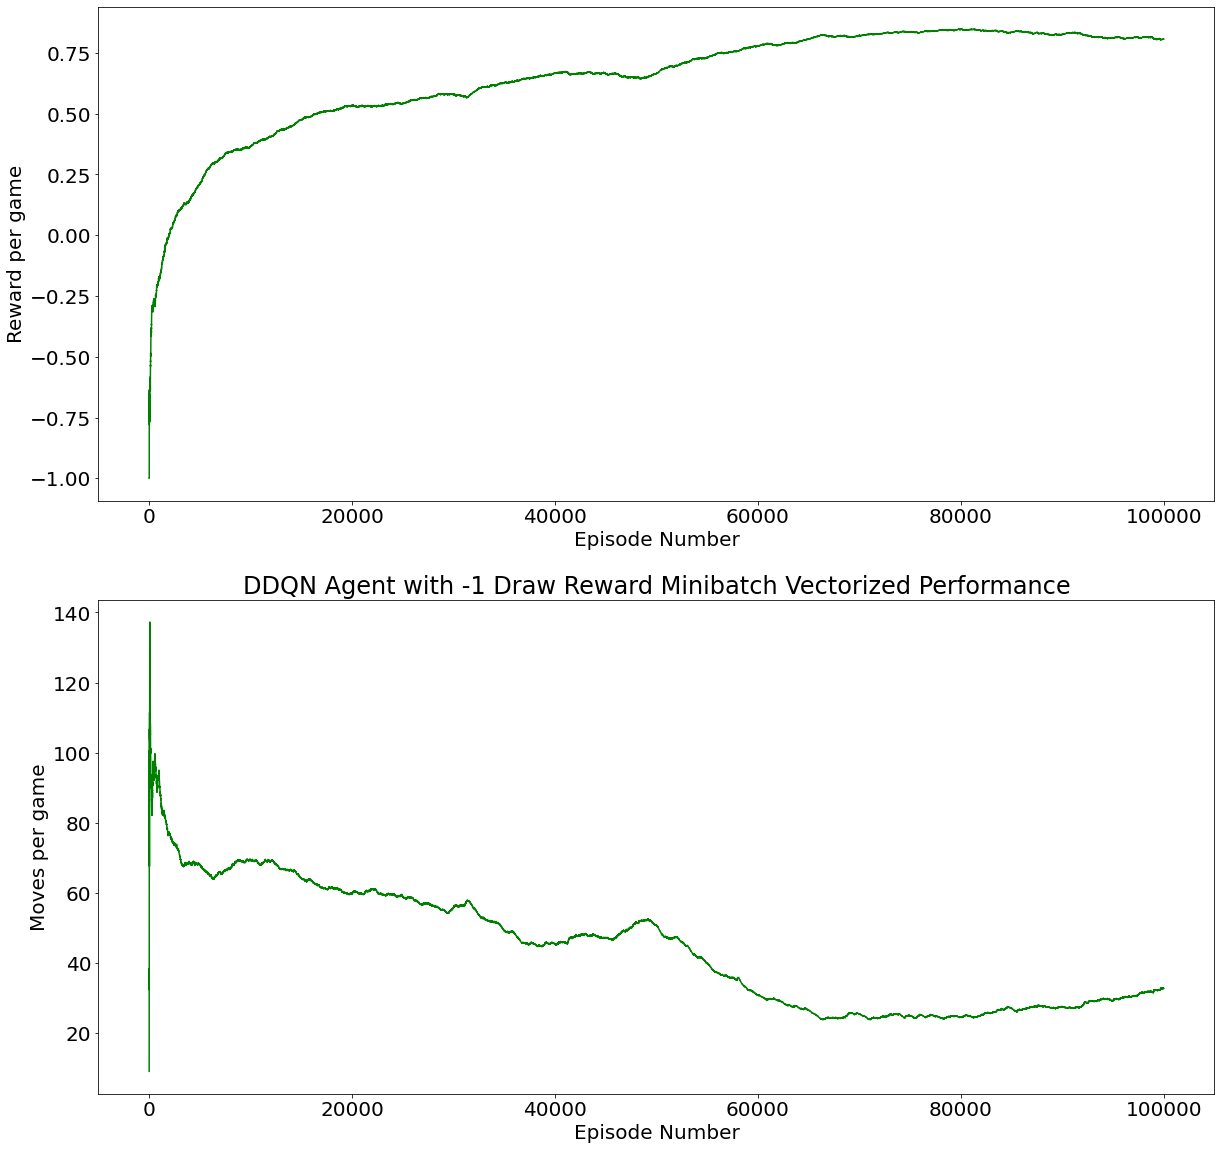

In [30]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 20})

## PLOT THE REWARD PER EPISODE AS TRAINING PROGRESSES
R_ema_DDQN_V = pd.DataFrame(R_save_DDQN_V).ewm(span=N_episodes/10).mean()
fig, (ax1, ax2)=plt.subplots(2,1)
ax1.plot(R_ema_DDQN_V, 'g')
ax1.set(xlabel='Episode Number', ylabel='Reward per game')

## PLOT THE NUMBER OF MOVES PER EPISODE AS TRAINING PROGRESSES
Moves_ema_DDQN_V = pd.DataFrame(N_moves_save_DDQN_V).ewm(span=N_episodes/10).mean()
ax2.plot(Moves_ema_DDQN_V, 'g')
ax2.set(xlabel='Episode Number', ylabel='Moves per game')
plt.title('DDQN Agent with -1 Draw Reward Minibatch Vectorized Performance')
plt.show()

## Varying beta for DDQN

  0%|          | 4/100000 [00:00<52:51, 31.53it/s]

DDQN Agent with beta: 1e-05  
Average reward: 0.55162 
Ave # of steps:  20.63585 
Draw %: 22.419 
Checkmate %: 77.581


  0%|          | 4/100000 [00:00<51:00, 32.68it/s]

DDQN Agent with beta: 5e-05  
Average reward: 0.68298 
Ave # of steps:  42.00092 
Draw %: 15.851 
Checkmate %: 84.149


100%|██████████| 100000/100000 [2:16:47<00:00, 12.18it/s]  


DDQN Agent with beta: 0.0001  
Average reward: 0.73636 
Ave # of steps:  53.17906 
Draw %: 13.182 
Checkmate %: 86.818


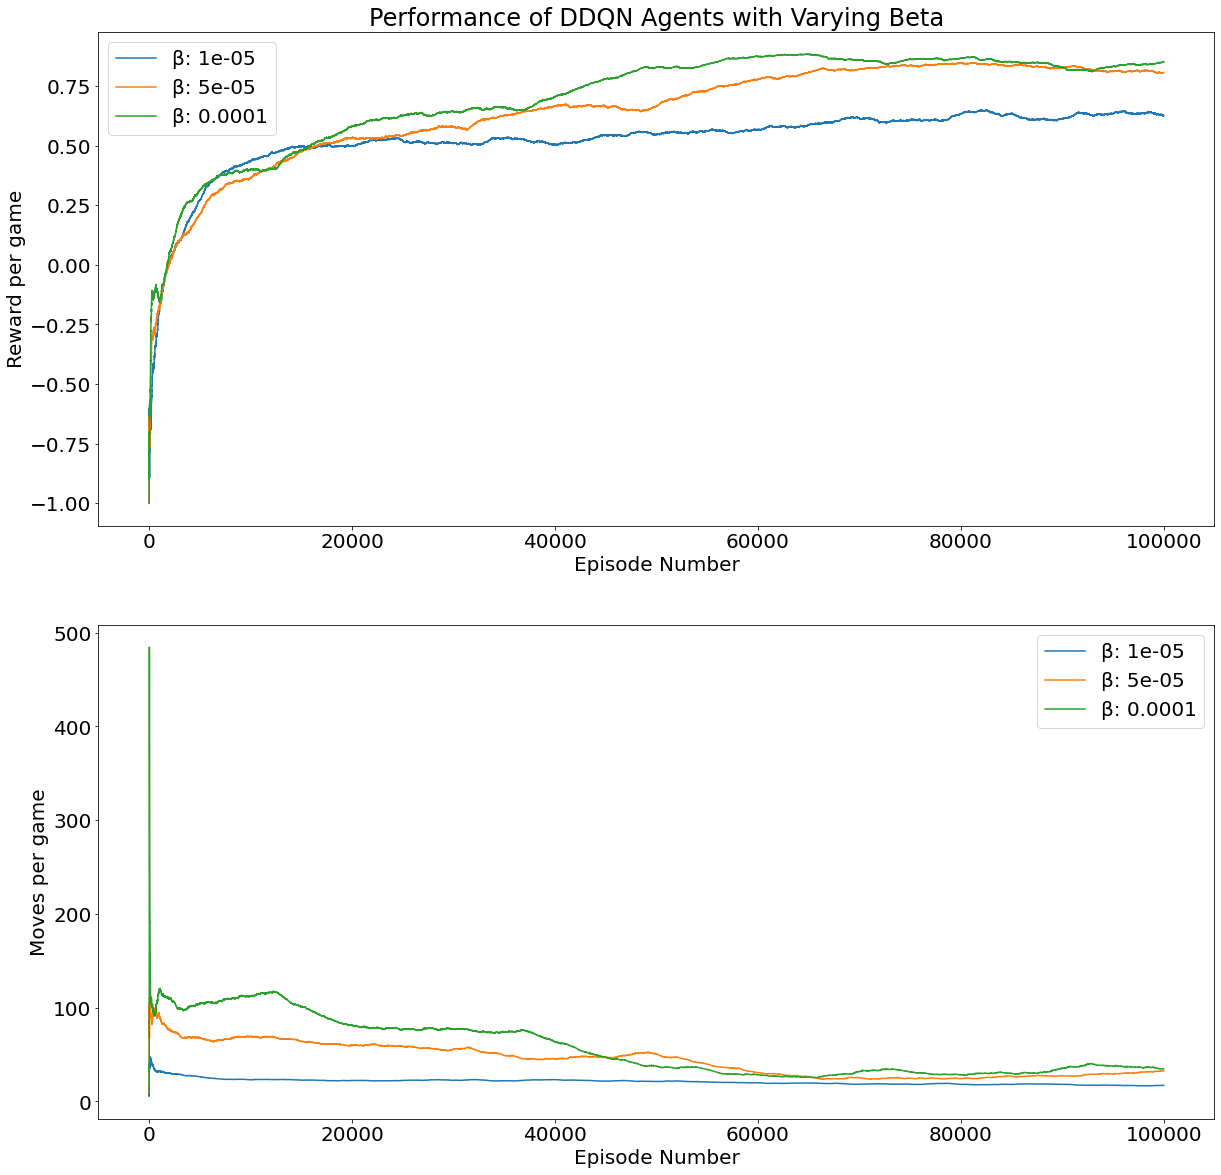

In [31]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2)=plt.subplots(2,1)
ax1.title.set_text('Performance of DDQN Agents with Varying Beta')
ax1.set(xlabel='Episode Number', ylabel='Reward per game')
ax2.set(xlabel='Episode Number', ylabel='Moves per game')

for beta in [0.00001, 0.00005, 0.0001]: # THE DISCOUNT FACTOR
    # INITIALISE THE ENVIRONMENT, PARAMETERS, AND THE NEURAL NETWORK 
    env=Chess_env_with_draw_punishment.Chess_Env(size_board)
    np.random.seed(2022)

    S,X,allowed_a=env.Initialise_game()
    N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

    N_in=np.shape(X)[0]    ## INPUT SIZE
    N_h=200                ## NUMBER OF HIDDEN NODES

    batch_size = 32
    N_experiences = 10000   #NUMBER OF EXPERIENCES WE KEEP IN THE REPLAY BUFFER
    N_episodes = 100000

    # HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

    epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
    eta = 0.01       # THE LEARNING RATE
    gamma = 0.85
    epsilon_f = epsilon_0   ## DECAYING EPSILON initialized first as EPSILON_0

    #Normalized Xavier Init: (sqrt(6.0) / sqrt(n_rows + n_cols))
    W1 = np.random.normal(0, scale=np.sqrt(6/(N_h + N_in)), size=(N_h, N_in))
    W2 = np.random.normal(0, scale=np.sqrt(6/(N_a + N_h)), size=(N_a, N_h))

    W1_target = W1.copy()
    W2_target = W2.copy()

    # Initialize the biases
    bias_W1 = np.zeros((N_h,))
    bias_W2 = np.zeros((N_a,))

    bias_W1_target = bias_W1.copy()
    bias_W2_target = bias_W2.copy()


    # SAVING VARIABLES
    R_save_DDQN_beta = np.zeros([N_episodes, 1])
    N_moves_save_DDQN_beta = np.zeros([N_episodes, 1])
    Draw_save_DDQN_beta = np.zeros([N_episodes, 1])
    Checkmate_save_DDQN_beta = np.zeros([N_episodes, 1])

    min_buffer_size= 100
    D = collections.deque(maxlen = N_experiences)
    counter_to_copy = 0
    time_to_copy = 200

    episodes_elapsed = 0
    S, X, allowed_a = env.Initialise_game()
    i = 0                                    ## COUNTER FOR NUMBER OF ACTIONS
    pbar = tqdm(total = N_episodes)

    while episodes_elapsed < N_episodes:

        # Find the Qvalues corresponding to that state
        # Neural activation: input layer -> hidden layer
        #h1 = np.dot(W1,X)+bias_W1
        h1 = np.dot(W1,X) + bias_W1
        # Apply the sigmoid function
        x1 = 1/(1+np.exp(-h1))

        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2

        # Apply the sigmoid function
        Qvalues = 1/(1+np.exp(-h2))

        # Make an action
        action = EpsilonGreedy_Policy(Qvalues, allowed_a.reshape(-1), epsilon_f)

        S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)

        #Store (s,a,r,s',Done) into buffer
        D.append((X, action, R, X_next, Done))  

        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S = np.copy(S_next)
        X = np.copy(X_next)
        allowed_a = np.copy(allowed_a_next)

        i+=1

        if Done:
            if R==1:   #if checkmate
                Checkmate_save_DDQN_beta[episodes_elapsed] = np.copy(1)
                Draw_save_DDQN_beta[episodes_elapsed] = np.copy(0)
            else:     #if draw
                Checkmate_save_DDQN_beta[episodes_elapsed] = np.copy(0)
                Draw_save_DDQN_beta[episodes_elapsed] = np.copy(1)

            R_save_DDQN_beta[episodes_elapsed] = np.copy(R)
            N_moves_save_DDQN_beta[episodes_elapsed] = np.copy(i)

            episodes_elapsed += 1
            S, X, allowed_a = env.Initialise_game()
            i=0
            epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON

            pbar.update(1)

        if len(D)<min_buffer_size:
            continue

        #This code runs after the buffer has enough samples to start training
        counter_to_copy += 1

        #Sample a random minibatch of experiences from D
        indices = np.random.randint(0, len(D), size=batch_size)    
        sampled_minibatch = [D[i] for i in indices]

        batch_array = np.array(sampled_minibatch, dtype=object)

        X_batch = np.transpose(np.stack(batch_array[:, 0]))  
        action_batch = np.array(batch_array[:, 1], dtype=int)
        R_batch = np.array(batch_array[:, 2], dtype=int)
        X_next_batch = np.transpose(np.stack(np.array(list(map(lambda row: row if len(row)>0 else np.zeros(X_batch.shape[0], dtype=int), batch_array[:, 3])), dtype=int)))
        Done_batch = np.array(batch_array[:, 4], dtype=int)


        #Compute the Q values
        h1 = np.dot(W1,X_batch) + np.tile(bias_W1, reps=[batch_size,1]).T
        # Apply the sigmoid function
        X1 = 1/(1+np.exp(-h1))
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,X1) + np.tile(bias_W2, reps=[batch_size,1]).T

        # Apply the sigmoid function
        Qvalues_batch = 1/(1+np.exp(-h2))

        #Calculate one-hot-encoding of the actions
        one_hot_action_batch = np.eye(32)[np.array(action_batch).reshape(-1)].T
        #Find the vector of Q values of the actions taken for each sample in the batch
        Q_taken_actions_batch = np.max(one_hot_action_batch * Qvalues_batch , axis=0)


        #Calculate Q_target using X_next_batch
        h1_next = np.dot(W1_target,X_next_batch)+np.tile(bias_W1_target, reps=[batch_size,1]).T
        # Apply the sigmoid function
        X1_next = 1/(1+np.exp(-h1_next))
        # Neural activation: hidden layer -> output layer
        h2_next = np.dot(W2_target,X1_next)+np.tile(bias_W2_target, reps=[batch_size,1]).T
        # Apply the sigmoid function
        Qvalues_target_batch = 1/(1+np.exp(-h2_next))

        #Calculate the error signal (combines Done=0 and Done=1 computations)
        e_n = one_hot_action_batch * (R_batch + gamma * (1-Done_batch) * np.max(Qvalues_target_batch, axis=0)  - Q_taken_actions_batch)
        #Realize: we use apply the backpropagation to the online Q network not the target network
        delta2 = e_n * Qvalues_batch * (1-Qvalues_batch)
        dbias_W2 = delta2
        dW2 = np.dot(delta2, X1.T)

        delta1 = X1*(1-X1) * np.dot(W2.T, delta2)
        dbias_W1 = delta1
        dW1 = np.dot(delta1, X_batch.T)

        #Update W1 and W2 only for the action taken
        W2 += eta*dW2/batch_size
        W1 += eta*dW1/batch_size
        bias_W2 += eta*np.mean(dbias_W2, axis=1)
        bias_W1 += eta*np.mean(dbias_W1, axis=1)

        if counter_to_copy % time_to_copy ==0:

            W1_target = np.copy(W1)
            W2_target = np.copy(W2)

            bias_W1_target = np.copy(bias_W1)
            bias_W2_target = np.copy(bias_W2)
    pbar.close()

    ## PLOT THE REWARD PER EPISODE AS TRAINING PROGRESSES
    R_ema_DDQN_beta = pd.DataFrame(R_save_DDQN_beta).ewm(span=N_episodes/10).mean()
    ax1.plot(R_ema_DDQN_beta, label="β: {}".format(beta))


    ## PLOT THE NUMBER OF MOVES PER EPISODE AS TRAINING PROGRESSES
    Moves_ema_DDQN_beta = pd.DataFrame(N_moves_save_DDQN_beta).ewm(span=N_episodes/10).mean()
    ax2.plot(Moves_ema_DDQN_beta, label="β: {}".format(beta))  
    print('DDQN Agent with beta: {} '.format(beta),'\nAverage reward:', np.mean(R_save_DDQN_beta),'\nAve # of steps: ', np.mean(N_moves_save_DDQN_beta), '\nDraw %:', 100*np.sum(Draw_save_DDQN_beta)/N_episodes, '\nCheckmate %:', 100*np.sum(Checkmate_save_DDQN_beta)/N_episodes)
ax1.legend() 
ax2.legend()
plt.show()

## Varying gamma for DDQN

  0%|          | 4/100000 [00:00<47:39, 34.97it/s]

DDQN Agent with gamma: 0.5  
Average reward: 0.50748 
Ave # of steps:  41.66203 
Draw %: 24.626 
Checkmate %: 75.374


  0%|          | 4/100000 [00:00<45:00, 37.02it/s]

DDQN Agent with gamma: 0.85  
Average reward: 0.68298 
Ave # of steps:  42.00092 
Draw %: 15.851 
Checkmate %: 84.149


100%|██████████| 100000/100000 [1:52:29<00:00, 14.82it/s] 


DDQN Agent with gamma: 0.95  
Average reward: 0.66872 
Ave # of steps:  43.82187 
Draw %: 16.564 
Checkmate %: 83.436


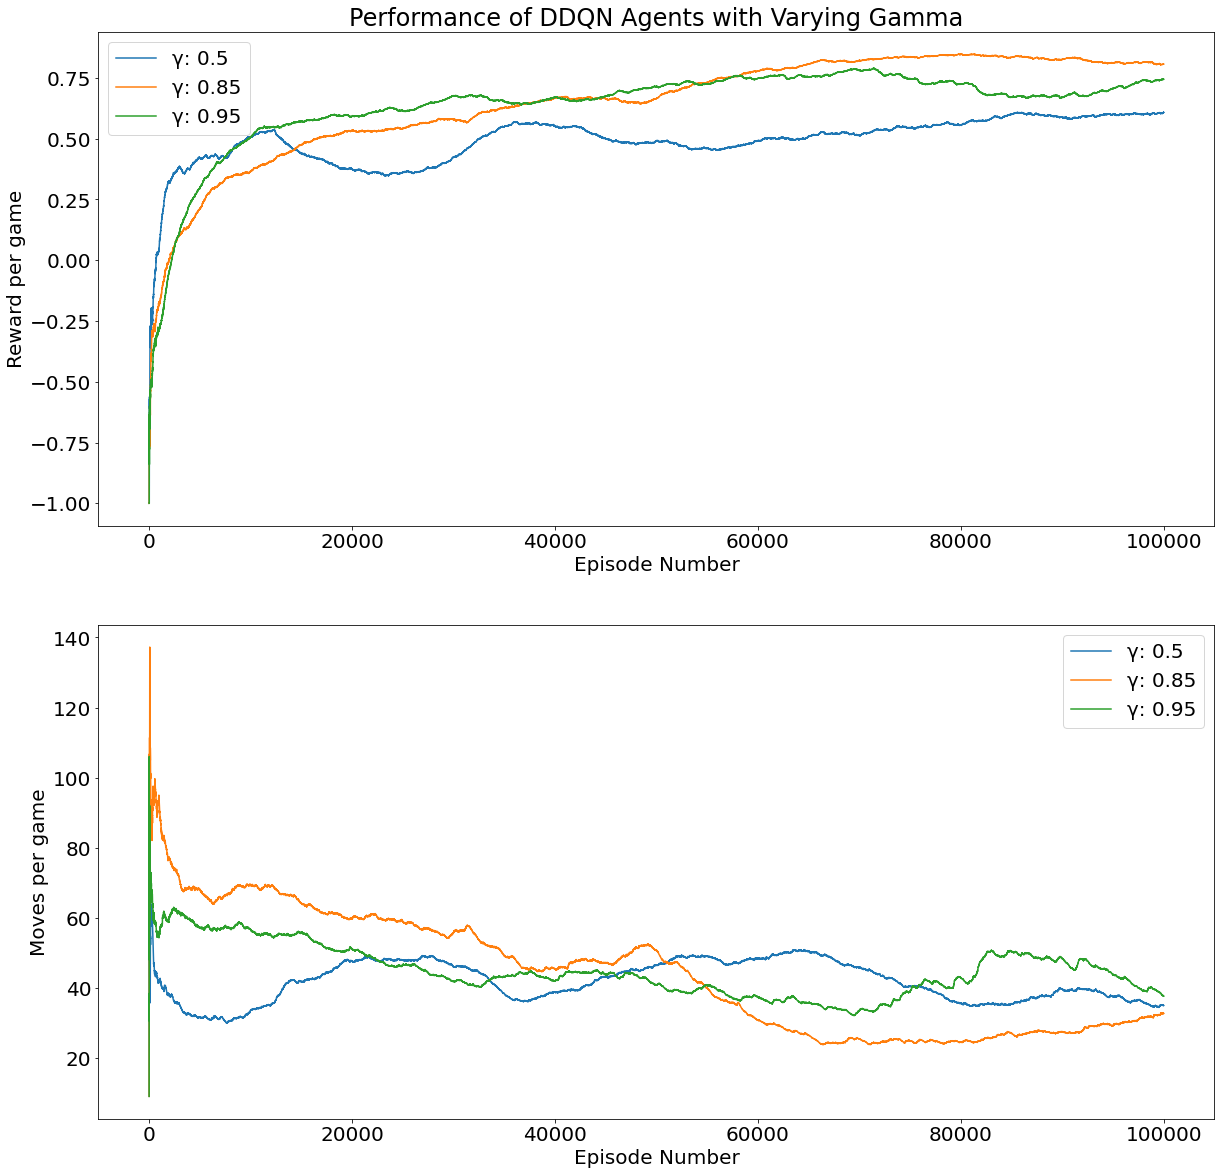

In [34]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2)=plt.subplots(2,1)
ax1.title.set_text('Performance of DDQN Agents with Varying Gamma')
ax1.set(xlabel='Episode Number', ylabel='Reward per game')
ax2.set(xlabel='Episode Number', ylabel='Moves per game')

for gamma in [0.5, 0.85, 0.95]: # THE DISCOUNT FACTOR
    # INITIALISE THE ENVIRONMENT, PARAMETERS, AND THE NEURAL NETWORK 
    env=Chess_env_with_draw_punishment.Chess_Env(size_board)
    np.random.seed(2022)

    S,X,allowed_a=env.Initialise_game()
    N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

    N_in=np.shape(X)[0]    ## INPUT SIZE
    N_h=200                ## NUMBER OF HIDDEN NODES

    batch_size = 32
    N_experiences = 10000   #NUMBER OF EXPERIENCES WE KEEP IN THE REPLAY BUFFER
    N_episodes = 100000

    # HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

    epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
    eta = 0.01       # THE LEARNING RATE
    beta = 0.00005
    epsilon_f = epsilon_0   ## DECAYING EPSILON initialized first as EPSILON_0

    #Normalized Xavier Init: (sqrt(6.0) / sqrt(n_rows + n_cols))
    W1 = np.random.normal(0, scale=np.sqrt(6/(N_h + N_in)), size=(N_h, N_in))
    W2 = np.random.normal(0, scale=np.sqrt(6/(N_a + N_h)), size=(N_a, N_h))

    W1_target = W1.copy()
    W2_target = W2.copy()

    # Initialize the biases
    bias_W1 = np.zeros((N_h,))
    bias_W2 = np.zeros((N_a,))

    bias_W1_target = bias_W1.copy()
    bias_W2_target = bias_W2.copy()


    # SAVING VARIABLES
    R_save_DDQN_gamma = np.zeros([N_episodes, 1])
    N_moves_save_DDQN_gamma = np.zeros([N_episodes, 1])
    Draw_save_DDQN_gamma = np.zeros([N_episodes, 1])
    Checkmate_save_DDQN_gamma = np.zeros([N_episodes, 1])

    min_buffer_size= 100
    D = collections.deque(maxlen = N_experiences)
    counter_to_copy = 0
    time_to_copy = 200

    episodes_elapsed = 0
    S, X, allowed_a = env.Initialise_game()
    i = 0                                    ## COUNTER FOR NUMBER OF ACTIONS
    pbar = tqdm(total = N_episodes)

    while episodes_elapsed < N_episodes:

        # Find the Qvalues corresponding to that state
        # Neural activation: input layer -> hidden layer
        #h1 = np.dot(W1,X)+bias_W1
        h1 = np.dot(W1,X) + bias_W1
        # Apply the sigmoid function
        x1 = 1/(1+np.exp(-h1))

        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2

        # Apply the sigmoid function
        Qvalues = 1/(1+np.exp(-h2))

        # Make an action
        action = EpsilonGreedy_Policy(Qvalues, allowed_a.reshape(-1), epsilon_f)

        S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)

        #Store (s,a,r,s',Done) into buffer
        D.append((X, action, R, X_next, Done))  

        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S = np.copy(S_next)
        X = np.copy(X_next)
        allowed_a = np.copy(allowed_a_next)

        i+=1

        if Done:
            if R==1:   #if checkmate
                Checkmate_save_DDQN_gamma[episodes_elapsed] = np.copy(1)
                Draw_save_DDQN_gamma[episodes_elapsed] = np.copy(0)
            else:     #if draw
                Checkmate_save_DDQN_gamma[episodes_elapsed] = np.copy(0)
                Draw_save_DDQN_gamma[episodes_elapsed] = np.copy(1)

            R_save_DDQN_gamma[episodes_elapsed] = np.copy(R)
            N_moves_save_DDQN_gamma[episodes_elapsed] = np.copy(i)

            episodes_elapsed += 1
            S, X, allowed_a = env.Initialise_game()
            i=0
            epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON

            pbar.update(1)

        if len(D)<min_buffer_size:
            continue

        #This code runs after the buffer has enough samples to start training
        counter_to_copy += 1

        #Sample a random minibatch of experiences from D
        indices = np.random.randint(0, len(D), size=batch_size)    
        sampled_minibatch = [D[i] for i in indices]

        batch_array = np.array(sampled_minibatch, dtype=object)

        X_batch = np.transpose(np.stack(batch_array[:, 0]))  
        action_batch = np.array(batch_array[:, 1], dtype=int)
        R_batch = np.array(batch_array[:, 2], dtype=int)
        X_next_batch = np.transpose(np.stack(np.array(list(map(lambda row: row if len(row)>0 else np.zeros(X_batch.shape[0], dtype=int), batch_array[:, 3])), dtype=int)))
        Done_batch = np.array(batch_array[:, 4], dtype=int)


        #Compute the Q values
        h1 = np.dot(W1,X_batch) + np.tile(bias_W1, reps=[batch_size,1]).T
        # Apply the sigmoid function
        X1 = 1/(1+np.exp(-h1))
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,X1) + np.tile(bias_W2, reps=[batch_size,1]).T

        # Apply the sigmoid function
        Qvalues_batch = 1/(1+np.exp(-h2))

        #Calculate one-hot-encoding of the actions
        one_hot_action_batch = np.eye(32)[np.array(action_batch).reshape(-1)].T
        #Find the vector of Q values of the actions taken for each sample in the batch
        Q_taken_actions_batch = np.max(one_hot_action_batch * Qvalues_batch , axis=0)


        #Calculate Q_target using X_next_batch
        h1_next = np.dot(W1_target,X_next_batch)+np.tile(bias_W1_target, reps=[batch_size,1]).T
        # Apply the sigmoid function
        X1_next = 1/(1+np.exp(-h1_next))
        # Neural activation: hidden layer -> output layer
        h2_next = np.dot(W2_target,X1_next)+np.tile(bias_W2_target, reps=[batch_size,1]).T
        # Apply the sigmoid function
        Qvalues_target_batch = 1/(1+np.exp(-h2_next))

        #Calculate the error signal (combines Done=0 and Done=1 computations)
        e_n = one_hot_action_batch * (R_batch + gamma * (1-Done_batch) * np.max(Qvalues_target_batch, axis=0)  - Q_taken_actions_batch)
        #Realize: we use apply the backpropagation to the online Q network not the target network
        delta2 = e_n * Qvalues_batch * (1-Qvalues_batch)
        dbias_W2 = delta2
        dW2 = np.dot(delta2, X1.T)

        delta1 = X1*(1-X1) * np.dot(W2.T, delta2)
        dbias_W1 = delta1
        dW1 = np.dot(delta1, X_batch.T)

        #Update W1 and W2 only for the action taken
        W2 += eta*dW2/batch_size
        W1 += eta*dW1/batch_size
        bias_W2 += eta*np.mean(dbias_W2, axis=1)
        bias_W1 += eta*np.mean(dbias_W1, axis=1)

        if counter_to_copy % time_to_copy ==0:

            W1_target = np.copy(W1)
            W2_target = np.copy(W2)

            bias_W1_target = np.copy(bias_W1)
            bias_W2_target = np.copy(bias_W2)
    pbar.close()

    ## PLOT THE REWARD PER EPISODE AS TRAINING PROGRESSES
    R_ema_DDQN_gamma = pd.DataFrame(R_save_DDQN_gamma).ewm(span=N_episodes/10).mean()
    ax1.plot(R_ema_DDQN_gamma, label="γ: {}".format(gamma))


    ## PLOT THE NUMBER OF MOVES PER EPISODE AS TRAINING PROGRESSES
    Moves_ema_DDQN_gamma = pd.DataFrame(N_moves_save_DDQN_gamma).ewm(span=N_episodes/10).mean()
    ax2.plot(Moves_ema_DDQN_gamma, label="γ: {}".format(gamma)) 
    print('DDQN Agent with gamma: {} '.format(gamma),'\nAverage reward:', np.mean(R_save_DDQN_gamma),'\nAve # of steps: ', np.mean(N_moves_save_DDQN_gamma), '\nDraw %:', 100*np.sum(Draw_save_DDQN_gamma)/N_episodes, '\nCheckmate %:', 100*np.sum(Checkmate_save_DDQN_gamma)/N_episodes)

ax1.legend() 
ax2.legend()
plt.show()